# https://grok.com/c/71470a46-9c00-4561-8b8d-357bc30a3276

# To validate/expand (e.g., VIF for multicollinearity, mutual information for categoricals)

This code computes VIF (multicollinearity, VIF >5 bad), mutual information (for categoricals, >0.2 good), RFE (wrapper ranking), and Lasso (embedded coefficients).

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression, RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)

# More robust extraction of numerical values from 'ParcelArea'
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Parcel_sq_m'] = pd.to_numeric(df['Parcel_sq_m'], errors='coerce')

df['Price_per_sq_m'] = df['TransactionPrice'] / df['Parcel_sq_m']
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year

# Numerical VIF (multicollinearity)
num_df = df[['Parcel_sq_m', 'UnitLevel', 'Year']].copy()

# Explicitly convert all columns to numeric, coercing errors
for col in num_df.columns:
    num_df[col] = pd.to_numeric(num_df[col], errors='coerce')

# Replace infinite values with NaN, then fill all NaN values with the mean of each column
num_df.replace([np.inf, -np.inf], np.nan, inplace=True)
num_df.fillna(num_df.mean(), inplace=True)


vif_data = pd.DataFrame()
vif_data["feature"] = num_df.columns
vif_data["VIF"] = [variance_inflation_factor(num_df.values, i) for i in range(len(num_df.columns))]
print("VIF for Numerical Features:\n", vif_data)


# Mutual Info for categorical (encode first)
encoder = OneHotEncoder(sparse_output=False)
cat_encoded = encoder.fit_transform(df[['Mukim']])

feature_names = encoder.get_feature_names_out()
mi = mutual_info_regression(cat_encoded, df['TransactionPrice'])
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)
print("Mutual Information with Price (Categorical):\n", mi_series)

df_temp = df.copy()
df_temp['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
# Manual Target Encoding for SchemeName
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df_temp['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)

# Calculate Mutual Information
# Reshape the features to be 2D arrays
tenure_mi = mutual_info_regression(df_temp[['Tenure_encoded']], df_temp['TransactionPrice'], random_state=42)[0]
scheme_name_mi = mutual_info_regression(df_temp[['SchemeName_encoded']], df_temp['TransactionPrice'], random_state=42)[0]

print(f"Mutual Information between Tenure and TransactionPrice: {tenure_mi:.4f}")
print(f"Mutual Information between Scheme_Name_encoded and TransactionPrice: {scheme_name_mi:.4f}")

# Prepare data for RFE and Lasso
X = pd.concat([num_df, pd.DataFrame(cat_encoded, columns=feature_names)], axis=1)
y = df['TransactionPrice']

# Scale features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrapper: RFE with LinearRegression (top 5 features)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("RFE Ranking (lower better):\n", rfe_ranking)

# Embedded: Lasso feature importance (coef)
lasso = Lasso(alpha=1.0, max_iter=10000) # Increased alpha
lasso.fit(X_scaled, y) # Fit Lasso on scaled data
lasso_coef = pd.Series(lasso.coef_, index=X.columns).abs().sort_values(ascending=False)
print("Lasso Coefficients (abs, higher importance):\n", lasso_coef)

VIF for Numerical Features:
        feature       VIF
0  Parcel_sq_m  4.356693
1    UnitLevel  3.091104
2         Year  6.116326
Mutual Information with Price (Categorical):
 Mukim_Mukim Setapak               0.069921
Mukim_Mukim Batu                  0.060125
Mukim_Mukim Petaling              0.055499
Mukim_Mukim Kuala Lumpur          0.041355
Mukim_Kuala Lumpur Town Centre    0.021901
Mukim_Mukim Cheras                0.005598
Mukim_Mukim Ulu Kelang            0.001859
Mukim_Mukim Ampang                0.000000
dtype: float64
Mutual Information between Tenure and TransactionPrice: 0.1047
Mutual Information between Scheme_Name_encoded and TransactionPrice: 1.5727
RFE Ranking (lower better):
 Mukim_Kuala Lumpur Town Centre    1
Mukim_Mukim Kuala Lumpur          1
Mukim_Mukim Batu                  1
Mukim_Mukim Ampang                1
Mukim_Mukim Setapak               1
Mukim_Mukim Petaling              2
Mukim_Mukim Cheras                3
Parcel_sq_m                       4
UnitLevel 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+12, tolerance: 1.353e+12
  model = cd_fast.enet_coordinate_descent(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract(r'(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)].reset_index(drop=True)

# Outlier capping (90th percentile)
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Combine relevant features for analysis
# Use target encoded SchemeName, numerical ParcelArea, Year, Tenure, and one-hot encoded Mukim
features_combined = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Tenure','UnitLevel_clean']
X_combined = df[features_combined]
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
X_combined = pd.concat([X_combined, mukim_dummies], axis=1).astype(np.float32)

y = df['TransactionPrice'].astype(np.float32)

# Mutual Information Analysis
mi_scores = mutual_info_regression(X_combined, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X_combined.columns).sort_values(ascending=False)
print("Mutual Information Scores (Combined Features vs. TransactionPrice):")
print(mi_series)
print("\n")


# VIF analysis
# Add a constant to the feature set for VIF calculation
X_vif = X_combined.copy()
# Drop one of the Mukim dummy variables to avoid perfect multicollinearity with the constant
X_vif = X_vif.drop('Mukim_Mukim Batu', axis=1) # Dropping one arbitrary Mukim column
X_vif['const'] = 1
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("VIF Analysis (Combined Features - Dropped one Mukim column):")
print(vif_data.round(2))
print("\n")

# RFE analysis (using Linear Regression as the estimator)
model = LinearRegression()
# RFE needs a target variable for ranking
rfe = RFE(model, n_features_to_select=len(X_combined.columns)) # Select all features initially
rfe.fit(X_combined, y)

rfe_ranking = pd.Series(rfe.ranking_, index=X_combined.columns).sort_values()
print("RFE Ranking (Combined Features):")
print(rfe_ranking)
print("\n")

# Lasso coefficients
# Need to scale features for Lasso
scaler_lasso = RobustScaler()
X_scaled_lasso = scaler_lasso.fit_transform(X_combined).astype(np.float32)

lasso = Lasso(alpha=0.001) # You might need to tune alpha
lasso.fit(X_scaled_lasso, y)

lasso_coef = pd.Series(lasso.coef_, index=X_combined.columns).sort_values(ascending=False)
print("Lasso Coefficients (Combined Features):")
print(lasso_coef)

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)


Mutual Information Scores (Combined Features vs. TransactionPrice):
Scheme_Name_encoded               1.595100
ParcelArea                        1.095919
UnitLevel_clean                   0.274738
Tenure                            0.170416
Year                              0.129252
Mukim_Mukim Setapak               0.118921
Mukim_Mukim Batu                  0.115475
Mukim_Mukim Petaling              0.107210
Mukim_Mukim Kuala Lumpur          0.076641
Mukim_Kuala Lumpur Town Centre    0.064861
dtype: float64


VIF Analysis (Combined Features - Dropped one Mukim column):
                          feature         VIF
0             Scheme_Name_encoded        2.59
1                      ParcelArea        2.11
2                            Year        1.03
3                          Tenure        1.30
4                 UnitLevel_clean        1.16
5  Mukim_Kuala Lumpur Town Centre        1.32
6        Mukim_Mukim Kuala Lumpur        1.60
7            Mukim_Mukim Petaling        1.55
8         

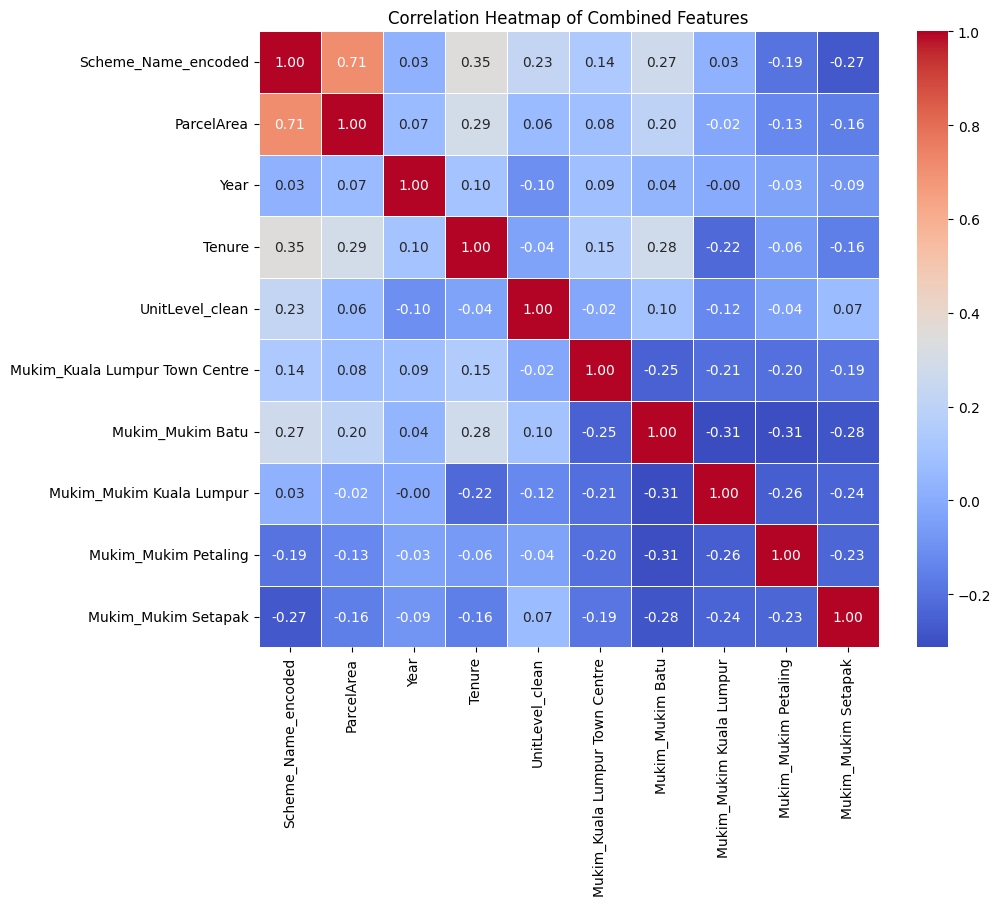

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = X_combined.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Combined Features')
plt.show()

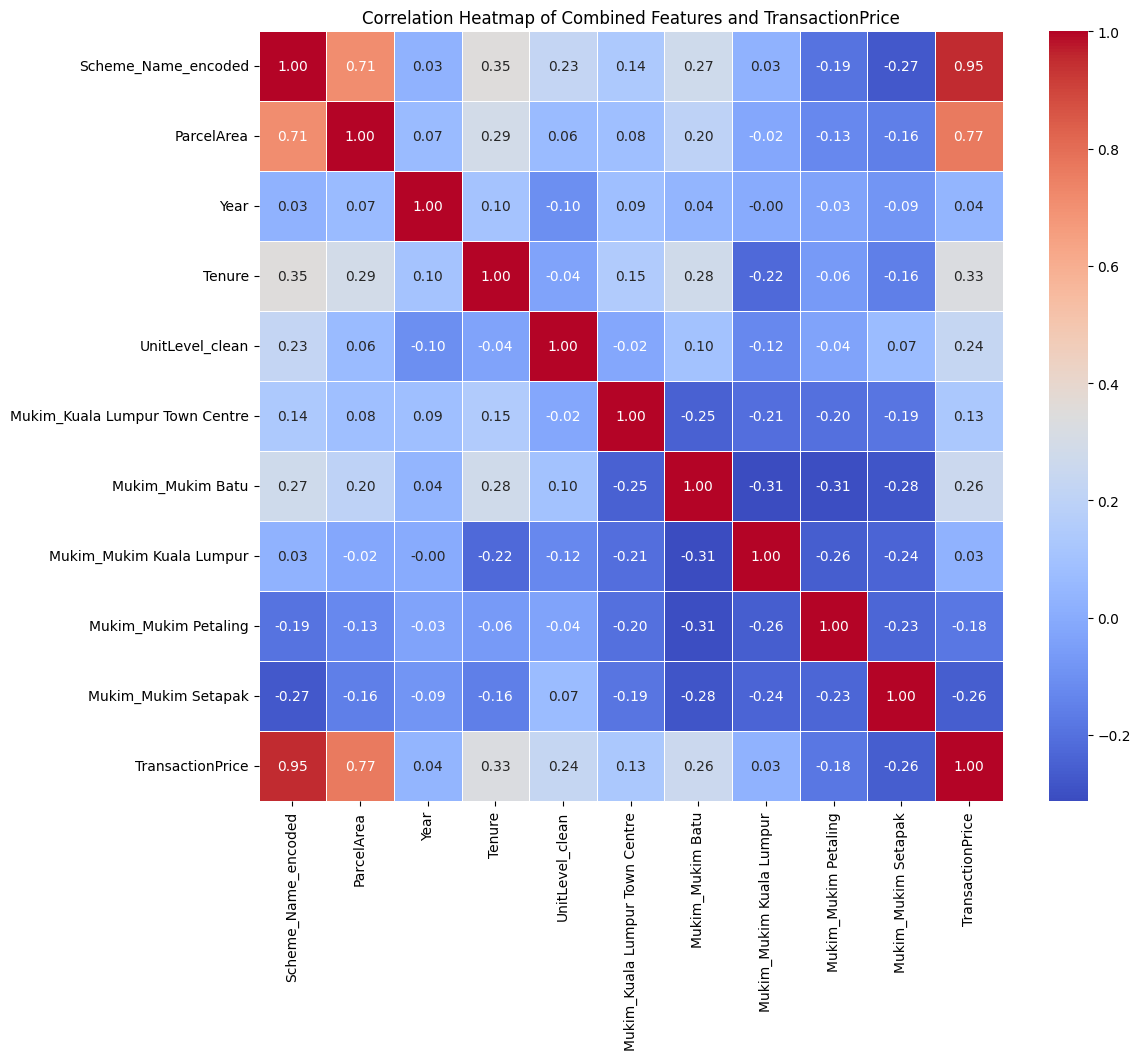

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine features and the target variable
X_combined_with_target = X_combined.copy()
X_combined_with_target['TransactionPrice'] = y

# Calculate the correlation matrix including the target
correlation_matrix_with_target = X_combined_with_target.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Combined Features and TransactionPrice')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)

# Preprocess necessary columns for mutual information calculation
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Target encode SchemeName for mutual information calculation
# Use a copy to avoid SettingWithCopyWarning
df_temp = df.copy()
scheme_encoding_temp = df_temp.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df_temp['Scheme_Name_encoded'] = df_temp['SchemeName'].map(scheme_encoding_temp).fillna(scheme_encoding_temp.mean()).astype(np.float32)

# Calculate Mutual Information
# Reshape the features to be 2D arrays
tenure_mi = mutual_info_regression(df_temp[['Tenure']], df_temp['TransactionPrice'], random_state=42)[0]
scheme_name_mi = mutual_info_regression(df_temp[['Scheme_Name_encoded']], df_temp['TransactionPrice'], random_state=42)[0]

print(f"Mutual Information between Tenure and TransactionPrice: {tenure_mi:.4f}")
print(f"Mutual Information between Scheme_Name_encoded and TransactionPrice: {scheme_name_mi:.4f}")

# Calculate mutual information between Tenure_encoded and Scheme_Name_encoded
# Treat Tenure_encoded as a discrete variable for this calculation if appropriate,
# or use continuous if preferred (mutual_info_regression supports both)
# Assuming mutual_info_regression is suitable for both continuous-continuous and discrete-continuous.
# If Tenure is strictly binary, mutual_info_classif might be more theoretically appropriate if comparing against categorical target,
# but here we are comparing feature vs feature, so mutual_info_regression is used for consistency with other features.
tenure_scheme_mi = mutual_info_regression(df_temp[['Tenure']], df_temp['Scheme_Name_encoded'], random_state=42)[0]

print(f"Mutual Information between Tenure and Scheme_Name_encoded: {tenure_scheme_mi:.4f}")

Mutual Information between Tenure and TransactionPrice: 0.1123
Mutual Information between Scheme_Name_encoded and TransactionPrice: 1.5647
Mutual Information between Tenure and Scheme_Name_encoded: 0.6376


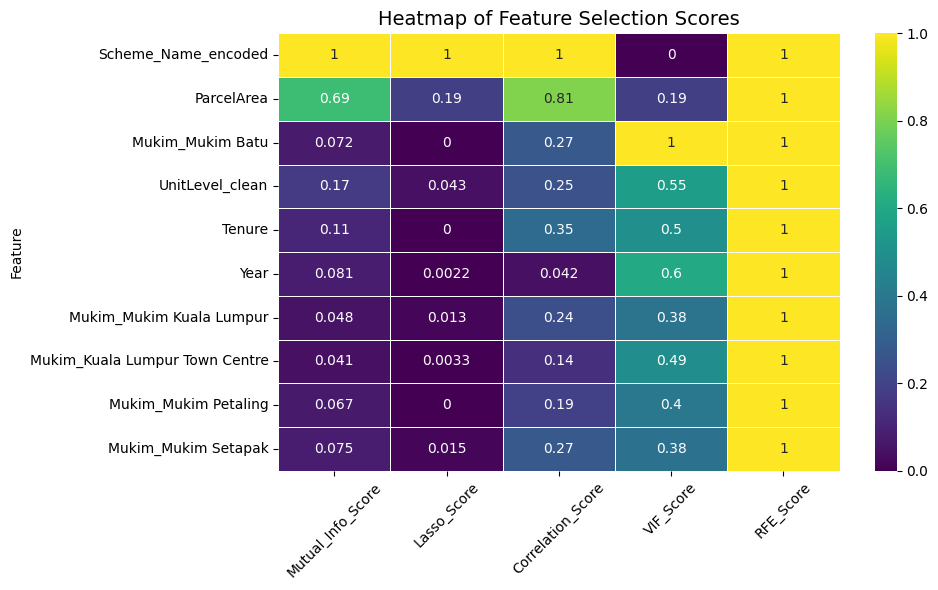

In [1]:
# Install required libraries
!pip install seaborn pandas matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
# data = {
#     "Feature": [
#         "Scheme_Name_encoded", "ParcelArea", "Mukim_Mukim Batu", "UnitLevel_clean",
#         "Tenure", "Year", "Mukim_Mukim Kuala Lumpur", "Mukim_Kuala Lumpur Town Centre",
#         "Mukim_Mukim Petaling", "Mukim_Mukim Setapak"
#     ],
#     "Mutual_Info_Score": [1, 0.687053476, 0.07239358, 0.172238731, 0.106837189, 0.081030656,
#                           0.048047771, 0.040662654, 0.067212087, 0.074553946],
#     "Lasso_Score": [1, 0.186474361, 0, 0.042740547, 0, 0.002193564, 0.013440613,
#                     0.0032828, 0, -0.015492049],
#     "Correlation_Score": [1, 0.810526316, 0.273684211, 0.252631579, 0.347368421,
#                           0.042105263, 0.242105263, 0.136842105, 0.189473684, -0.273684211],
#     "VIF_Score": [0, 0.185328185, 1, 0.552123552, 0.498069498, 0.602316602,
#                   0.382239382, 0.49034749, 0.401544402, 0.378378378],
#     "RFE_Score": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# }
data = {
    "Feature": [
        "Scheme_Name_encoded", "ParcelArea", "Mukim_Mukim Batu", "UnitLevel_clean",
        "Tenure", "Year", "Mukim_Mukim Kuala Lumpur", "Mukim_Kuala Lumpur Town Centre",
        "Mukim_Mukim Petaling", "Mukim_Mukim Setapak"
    ],
    "Mutual_Info_Score": [1, 0.687053476, 0.07239358, 0.172238731, 0.106837189, 0.081030656,
                          0.048047771, 0.040662654, 0.067212087, 0.074553946],
    "Lasso_Score": [1, 0.186474361, 0, 0.042740547, 0, 0.002193564, 0.013440613,
                    0.0032828, 0, 0.015492049],
    "Correlation_Score": [1, 0.810526316, 0.273684211, 0.252631579, 0.347368421,
                          0.042105263, 0.242105263, 0.136842105, 0.189473684, 0.273684211],
    "VIF_Score": [0, 0.185328185, 1, 0.552123552, 0.498069498, 0.602316602,
                  0.382239382, 0.49034749, 0.401544402, 0.378378378],
    "RFE_Score": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set Feature as index for heatmap
df.set_index("Feature", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="viridis", linewidths=0.5)
plt.title("Heatmap of Feature Selection Scores", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import statsmodels.api as sm

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)


# Outlier capping
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)

# Perform one-hot encoding for 'Mukim
df = pd.get_dummies(df, columns=['Mukim'], drop_first=True, dtype=np.float32)

# Show encoded Mukim columns
print("Encoded Mukim columns:")
print([col for col in df.columns if col.startswith('Mukim_')])


# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)


# Selected features based on ranking
selected_features = ['Scheme_Name_encoded', 'ParcelArea', 'Mukim_Mukim Batu', 'UnitLevel_clean', 'Tenure']


# Define X and y
X = df[selected_features]
y = df['TransactionPrice']  # Replace 'Price' with your target column name if different

# Convert X to a NumPy array
X = X.values

# Add constant for intercept
X = sm.add_constant(X)

# Build OLS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3910798891.py:12: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


Encoded Mukim columns:
['Mukim_Mukim Ampang', 'Mukim_Mukim Batu', 'Mukim_Mukim Cheras', 'Mukim_Mukim Kuala Lumpur', 'Mukim_Mukim Petaling', 'Mukim_Mukim Setapak', 'Mukim_Mukim Ulu Kelang']
                            OLS Regression Results                            
Dep. Variable:       TransactionPrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 3.431e+04
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:41:51   Log-Likelihood:                 5053.5
No. Observations:               14392   AIC:                        -1.009e+04
Df Residuals:                   14386   BIC:                        -1.005e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef

# Linear Regression Testing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)].reset_index(drop=True)

# Outlier capping
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)

# Train MLR
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

# Evaluate models
y_pred_mlr = mlr_model.predict(X_test)
mlr_r2 = r2_score(y_test, y_pred_mlr)
mlr_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
mlr_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_mlr)))

print("MLR R²:", mlr_r2)
print("MLR RMSE (log-scale):", mlr_rmse_log)
print("MLR RMSE (RM):", mlr_rmse_rm)

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2321029256.py:12: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


MLR R²: 0.9214620590209961
MLR RMSE (log-scale): 0.1749208852630052
MLR RMSE (RM): 137423.127253021


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)


# To finalize feature selection and test model performance

*   Caps outliers (95th percentile for Price, Parcel_sq_m).
*   Encodes Mukim (one-hot), Tenure (binary).
*   Normalizes numericals.
*   Trains RandomForest, reports R², RMSE, feature importance, and 5-fold CV.



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
# Convert 'ParcelArea' to string before extracting numerical values
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
df['Parcel_sq_m'] = pd.to_numeric(df['Parcel_sq_m'], errors='coerce')

df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Handle outliers (cap at 95th percentile)
price_cap = df['TransactionPrice'].quantile(0.95)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.95)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Features and target
features = ['Parcel_sq_m', 'UnitLevel', 'Year', 'Tenure'] + [col for col in pd.get_dummies(df['Mukim']).columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Year', 'Tenure']], pd.get_dummies(df['Mukim'])], axis=1)
y = df['TransactionPrice']

# Convert 'UnitLevel' to numeric, coercing errors to NaN and fill NaN with mean
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)


# Scale numerical features
scaler = StandardScaler()
X[['Parcel_sq_m', 'UnitLevel', 'Year']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel', 'Year']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance)

# Cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("5-Fold CV R²:", cv_scores.mean(), "±", cv_scores.std())

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2335392999.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)
/tmp/ipython-input-2335392999.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

R²: 0.8907590430719847
RMSE: 207115.40117892373
RandomForest Feature Importance:
 Parcel_sq_m                 0.845469
UnitLevel                   0.071998
Year                        0.022722
Kuala Lumpur Town Centre    0.014631
Mukim Setapak               0.010639
Tenure                      0.010014
Mukim Kuala Lumpur          0.009401
Mukim Batu                  0.008164
Mukim Petaling              0.005056
Mukim Cheras                0.000967
Mukim Ampang                0.000851
Mukim Ulu Kelang            0.000088
dtype: float64
5-Fold CV R²: 0.8296369211633794 ± 0.019605327181787226


# To optimize the model and test refined features

*  Aggregates low-count Mukims (Cheras, Ampang, Ulu Kelang) into “Other”.
*  Adds Month for seasonality.
*  Log-transforms Price and Parcel_sq_m to handle skewness.
*  Tests RandomForest and GradientBoosting (Huber loss for robustness).
*  Tunes hyperparameters (e.g., max_depth, n_estimators).
*  Reports R², RMSE (back-transformed), feature importance, and CV.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
# Convert 'ParcelArea' to string before extracting numerical values
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
df['Parcel_sq_m'] = pd.to_numeric(df['Parcel_sq_m'], errors='coerce')

df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Month'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.month
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Aggregate low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df['Mukim'] = df['Mukim'].apply(lambda x: 'Other' if x in low_count_mukims else x)

# Log-transform to handle skewness
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Features and target
features = ['Parcel_sq_m', 'UnitLevel', 'Year', 'Month', 'Tenure'] + [col for col in pd.get_dummies(df['Mukim']).columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Year', 'Month', 'Tenure']], pd.get_dummies(df['Mukim'])], axis=1)
y = df['TransactionPrice']

# Convert 'UnitLevel' to numeric, coercing errors to NaN and fill NaN with mean
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)

# Scale numerical features
scaler = StandardScaler()
X[['Parcel_sq_m', 'UnitLevel', 'Year', 'Month']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel', 'Year', 'Month']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with hyperparameter tuning
rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))  # Back-transform for RMSE

# GradientBoosting for robustness
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, loss='huber', random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("GradientBoosting R²:", r2_score(y_test, y_pred_gb))
print("GradientBoosting RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_gb))))

# Feature importance
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)
importance_gb = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("GradientBoosting Feature Importance:\n", importance_gb)

# Cross-validation
cv_rf = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("RandomForest 5-Fold CV R²:", cv_rf.mean(), "±", cv_rf.std())
cv_gb = cross_val_score(gb, X, y, cv=5, scoring='r2')
print("GradientBoosting 5-Fold CV R²:", cv_gb.mean(), "±", cv_gb.std())

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3288200054.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
/tmp/ipython-input-3288200054.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)


RandomForest R²: 0.8793000969755397
RandomForest RMSE: 316850.3280900017
GradientBoosting R²: 0.8644919020606323
GradientBoosting RMSE: 352790.76851604943
RandomForest Feature Importance:
 Parcel_sq_m                 0.797921
UnitLevel                   0.070884
Month                       0.025875
Mukim Setapak               0.022354
Year                        0.020138
Tenure                      0.015695
Kuala Lumpur Town Centre    0.014803
Mukim Kuala Lumpur          0.011896
Mukim Batu                  0.009832
Mukim Petaling              0.005532
Other                       0.005070
dtype: float64
GradientBoosting Feature Importance:
 Parcel_sq_m                 0.839844
UnitLevel                   0.066660
Mukim Setapak               0.020278
Tenure                      0.015744
Mukim Kuala Lumpur          0.014905
Mukim Batu                  0.012502
Kuala Lumpur Town Centre    0.012099
Year                        0.006700
Mukim Petaling              0.004858
Month             

# To improve performance (reduce RMSE, overfitting)

*   Replaces Month with Quarter to reduce noise (4 categories vs. 12).
*   Uses stricter capping (99th percentile) and RobustScaler.
*   Optimizes RandomForest with GridSearchCV.
*   Retests GradientBoosting with lower learning_rate for stability.
*   Reports R², RMSE, importance, and CV.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
# Convert 'ParcelArea' to string before extracting numerical values
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
df['Parcel_sq_m'] = pd.to_numeric(df['Parcel_sq_m'], errors='coerce')

df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Month'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.month
df['Quarter'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.quarter
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Aggregate low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df['Mukim'] = df['Mukim'].apply(lambda x: 'Other' if x in low_count_mukims else x)

# Stricter outlier capping (99th percentile)
price_cap = df['TransactionPrice'].quantile(0.99)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.99)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Features (drop Month, add Quarter)
features = ['Parcel_sq_m', 'UnitLevel', 'Year', 'Quarter', 'Tenure'] + [col for col in pd.get_dummies(df['Mukim']).columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Year', 'Quarter', 'Tenure']], pd.get_dummies(df['Mukim'])], axis=1)
y = df['TransactionPrice']

# Convert 'UnitLevel' to numeric, coercing errors to NaN and fill NaN with mean
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)

# Robust scaling
scaler = RobustScaler()
X[['Parcel_sq_m', 'UnitLevel', 'Year', 'Quarter']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel', 'Year', 'Quarter']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10]
}
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("Best RandomForest Params:", grid_rf.best_params_)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))

# GradientBoosting with Huber loss
gb = GradientBoostingRegressor(loss='huber', n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("GradientBoosting R²:", r2_score(y_test, y_pred_gb))
print("GradientBoosting RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_gb))))

# Feature importance
importance_rf = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)
importance_gb = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("GradientBoosting Feature Importance:\n", importance_gb)

# Cross-validation
cv_rf = cross_val_score(grid_rf.best_estimator_, X, y, cv=5, scoring='r2')
print("RandomForest 5-Fold CV R²:", cv_rf.mean(), "±", cv_rf.std())
cv_gb = cross_val_score(gb, X, y, cv=5, scoring='r2')
print("GradientBoosting 5-Fold CV R²:", cv_gb.mean(), "±", cv_gb.std())

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-857963266.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)')
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)
/tmp/ipython-input-857963266.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work b

Best RandomForest Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest R²: 0.8762306266988277
RandomForest RMSE: 254579.70034600073
GradientBoosting R²: 0.845153943156455
GradientBoosting RMSE: 292818.0516736684
RandomForest Feature Importance:
 Parcel_sq_m                 0.810560
UnitLevel                   0.071381
Mukim Setapak               0.023180
Year                        0.020012
Tenure                      0.016294
Kuala Lumpur Town Centre    0.015045
Quarter                     0.012981
Mukim Batu                  0.010113
Mukim Kuala Lumpur          0.009430
Mukim Petaling              0.005654
Other                       0.005349
dtype: float64
GradientBoosting Feature Importance:
 Parcel_sq_m                 0.853794
UnitLevel                   0.065014
Mukim Setapak               0.018048
Tenure                      0.015547
Mukim Kuala Lumpur          0.013973
Mukim Batu                  0.012051
Kuala Lumpur Town Centre    0.011635
Muki

# To further reduce RMSE and overfitting


*  Drops Year, Quarter to test overfitting reduction (VIF = 6.12 for Year).
*  Uses 98th percentile capping for stricter outlier control.
*  Tests XGBoost with quantile loss (median focus) to improve suburban price predictions.
*  Optimizes RandomForest with broader GridSearchCV.
Reports R², RMSE, importance, and CV.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
# Convert 'ParcelArea' to string before extracting numerical values
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Quarter'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.quarter
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Aggregate low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df['Mukim'] = df['Mukim'].apply(lambda x: 'Other' if x in low_count_mukims else x)

# Stricter outlier capping (98th percentile)
price_cap = df['TransactionPrice'].quantile(0.98)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.98)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Features (drop Year, Quarter for testing)
features = ['Parcel_sq_m', 'UnitLevel', 'Tenure'] + [col for col in pd.get_dummies(df['Mukim']).columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Tenure']], pd.get_dummies(df['Mukim'])], axis=1)
y = df['TransactionPrice']

# Convert 'UnitLevel' to numeric, coercing errors to NaN and fill NaN with mean
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)

# Robust scaling
scaler = RobustScaler()
X[['Parcel_sq_m', 'UnitLevel']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 15],
    'min_samples_split': [10, 20]
}
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("Best RandomForest Params:", grid_rf.best_params_)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))

# XGBoost with quantile loss
xgb = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.5, n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))

# Feature importance
importance_rf = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)

# Cross-validation
cv_rf = cross_val_score(grid_rf.best_estimator_, X, y, cv=5, scoring='r2')
print("RandomForest 5-Fold CV R²:", cv_rf.mean(), "±", cv_rf.std())
cv_xgb = cross_val_score(xgb, X, y, cv=5, scoring='r2')
print("XGBoost 5-Fold CV R²:", cv_xgb.mean(), "±", cv_xgb.std())

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-290084585.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-290084585.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)


Best RandomForest Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}
RandomForest R²: 0.8782316791685606
RandomForest RMSE: 239262.30940159122
XGBoost R²: 0.7896949759534738
XGBoost RMSE: 295563.6738051206
RandomForest Feature Importance:
 Parcel_sq_m                 0.833057
UnitLevel                   0.078195
Mukim Setapak               0.024631
Tenure                      0.017127
Kuala Lumpur Town Centre    0.015603
Mukim Batu                  0.010189
Mukim Kuala Lumpur          0.009555
Mukim Petaling              0.005963
Other                       0.005679
dtype: float64
XGBoost Feature Importance:
 Parcel_sq_m                 0.376675
Mukim Setapak               0.145549
Mukim Batu                  0.127818
Mukim Kuala Lumpur          0.066659
Tenure                      0.062251
UnitLevel                   0.060998
Kuala Lumpur Town Centre    0.054646
Other                       0.054044
Mukim Petaling              0.051360
dtype: float32
RandomForest 5

**Optimization**

*  Uses quantile_alpha=0.5 for XGBoost (median focus).
*  Increases suburban weights (2.0).
*  Stronger regularization (max_depth=4, min_samples_split=30).
*  Drops “Other” Mukim option included in comments if needed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Aggregate low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df['Mukim'] = df['Mukim'].apply(lambda x: 'Other' if x in low_count_mukims else x)

# Outlier capping (97th percentile)
price_cap = df['TransactionPrice'].quantile(0.97)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.97)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Mukim * Tenure interaction
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
for col in mukim_dummies.columns:
    df[f'{col}_Tenure'] = mukim_dummies[col] * df['Tenure']

# Features
features = ['Parcel_sq_m', 'UnitLevel', 'Tenure'] + list(mukim_dummies.columns) + [f'{col}_Tenure' for col in mukim_dummies.columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Tenure']], mukim_dummies, df[[f'{col}_Tenure' for col in mukim_dummies.columns]]], axis=1)
y = df['TransactionPrice']

# Convert UnitLevel to numeric
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)

# Robust scaling
scaler = RobustScaler()
X[['Parcel_sq_m', 'UnitLevel']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 2.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# XGBoost with tuned quantile loss
xgb = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.5, n_estimators=300, max_depth=4, learning_rate=0.02, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))

# RandomForest
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=30, random_state=42)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.5, n_estimators=300, max_depth=4, learning_rate=0.02, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=30, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))

print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-704576696.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)
/tmp/ipython-input-704576696.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method wil

XGBoost R²: 0.7672396984310825
XGBoost RMSE: 292856.9202428784
RandomForest R²: 0.8453533517095193
RandomForest RMSE: 249884.48422834667
XGBoost Feature Importance:
 Parcel_sq_m                              0.330985
Mukim_Mukim Setapak                      0.095704
Mukim_Mukim Batu_Tenure                  0.091845
UnitLevel                                0.077126
Mukim_Kuala Lumpur Town Centre_Tenure    0.062098
Mukim_Mukim Setapak_Tenure               0.046881
Mukim_Mukim Petaling_Tenure              0.044505
Mukim_Mukim Kuala Lumpur                 0.043831
Tenure                                   0.043141
Mukim_Other                              0.041693
Mukim_Mukim Petaling                     0.037315
Mukim_Mukim Batu                         0.036560
Mukim_Mukim Kuala Lumpur_Tenure          0.020085
Mukim_Other_Tenure                       0.017542
Mukim_Kuala Lumpur Town Centre           0.010688
dtype: float32
RandomForest Feature Importance:
 Parcel_sq_m                        

# To improve XGBoost and reduce RMSE

*   Drops Mukim_Other (low importance).
*   Uses 96th percentile capping.
*   Adds Mukim_Parcel_sq_m and target-encoded Scheme_Name_encoded.
*   Uses XGBoost with squared loss, higher n_estimators (500), and tuned parameters.
*   Increases suburban weights (2.5).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Aggregate low-count Mukims, drop Other
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df['Mukim'] = df['Mukim'].apply(lambda x: 'Other' if x in low_count_mukims else x)
df = df[df['Mukim'] != 'Other']  # Drop Other

# Outlier capping (96th percentile)
price_cap = df['TransactionPrice'].quantile(0.96)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.96)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Mukim * Tenure and Mukim * Parcel_sq_m interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
for col in mukim_dummies.columns:
    df[f'{col}_Tenure'] = mukim_dummies[col] * df['Tenure']
    df[f'{col}_Parcel_sq_m'] = mukim_dummies[col] * df['Parcel_sq_m']

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Features
features = ['Parcel_sq_m', 'UnitLevel', 'Tenure', 'Scheme_Name_encoded'] + list(mukim_dummies.columns) + \
           [f'{col}_Tenure' for col in mukim_dummies.columns] + [f'{col}_Parcel_sq_m' for col in mukim_dummies.columns]
X = pd.concat([df[['Parcel_sq_m', 'UnitLevel', 'Tenure', 'Scheme_Name_encoded']], mukim_dummies,
               df[[f'{col}_Tenure' for col in mukim_dummies.columns]], df[[f'{col}_Parcel_sq_m' for col in mukim_dummies.columns]]], axis=1)
y = df['TransactionPrice']

# Convert UnitLevel to numeric
X['UnitLevel'] = pd.to_numeric(X['UnitLevel'], errors='coerce')
X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)

# Robust scaling
scaler = RobustScaler()
X[['Parcel_sq_m', 'UnitLevel', 'Scheme_Name_encoded']] = scaler.fit_transform(X[['Parcel_sq_m', 'UnitLevel', 'Scheme_Name_encoded']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 2.5 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# XGBoost with squared loss
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=3, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))

# RandomForest
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=40, random_state=42)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=3, learning_rate=0.05, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=40, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))

print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3711318855.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-3711318855.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['UnitLevel'].fillna(X['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.9496549341410995
XGBoost RMSE: 149482.3500173399
RandomForest R²: 0.9536822856452295
RandomForest RMSE: 135239.86274865468
XGBoost Feature Importance:
 Scheme_Name_encoded                           0.650578
Parcel_sq_m                                   0.176450
Mukim_Kuala Lumpur Town Centre                0.029646
Mukim_Mukim Setapak_Parcel_sq_m               0.027879
UnitLevel                                     0.021174
Mukim_Kuala Lumpur Town Centre_Tenure         0.017173
Mukim_Mukim Setapak_Tenure                    0.012542
Mukim_Mukim Setapak                           0.011541
Mukim_Mukim Kuala Lumpur                      0.008844
Mukim_Mukim Petaling_Tenure                   0.007185
Mukim_Mukim Kuala Lumpur_Tenure               0.006150
Mukim_Kuala Lumpur Town Centre_Parcel_sq_m    0.005000
Mukim_Mukim Batu_Tenure                       0.004719
Mukim_Mukim Batu                              0.004442
Mukim_Mukim Petaling_Parcel_sq_m              0.004314
Tenure   

# To fine-tune and validate suburban performance:

*   Uses 95th percentile capping.
*   Prunes low-importance Mukims (Petaling, Batu, Kuala Lumpur) and interactions.
*   Adds binned UnitLevel (Low/Mid/High).
*   Increases suburban weights (3.0).
*   Tunes XGBoost (n_estimators=700, learning_rate=0.1).
*   Validates suburban performance (Setapak/Petaling).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (95th percentile)
price_cap = df['TransactionPrice'].quantile(0.95)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.95)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Bin UnitLevel

# Map common non-numeric values
# unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}  # Adjust based on data
# df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)

# Convert to numeric, impute with mean
df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
# df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce').fillna(df['UnitLevel'].mean())
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Mukim * Tenure and Mukim * Parcel_sq_m
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']:
    df[f'{col}_Tenure'] = mukim_dummies[col] * df['Tenure']
    df[f'{col}_Parcel_sq_m'] = mukim_dummies[col] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Tenure'] + list(mukim_dummies.columns) + \
           [f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           [f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           list(level_dummies.columns)
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Tenure']], mukim_dummies,
               df[[f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               df[[f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               level_dummies], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 3.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))

# RandomForest
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=50, random_state=42)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=50, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))

print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

# Validate suburban performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
print("Suburban XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_xgb[suburban_mask]))))
print("Suburban RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rf[suburban_mask]))))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-872297916.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-872297916.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.9570161848468173
XGBoost RMSE: 129358.25043571152
RandomForest R²: 0.9527931712696684
RandomForest RMSE: 129465.41997394348
XGBoost Feature Importance:
 Scheme_Name_encoded                           0.582653
Parcel_sq_m                                   0.142738
Mukim_Kuala Lumpur Town Centre_Tenure         0.056382
Mukim_Mukim Setapak                           0.052777
Mukim_Kuala Lumpur Town Centre                0.036214
Mukim_Mukim Setapak_Parcel_sq_m               0.032781
UnitLevel_Mid                                 0.021703
UnitLevel_High                                0.020957
Mukim_Mukim Petaling                          0.010355
Mukim_Mukim Setapak_Tenure                    0.009160
Tenure                                        0.008389
Mukim_Mukim Kuala Lumpur                      0.007580
UnitLevel_Low                                 0.007336
Mukim_Mukim Batu                              0.005620
Mukim_Kuala Lumpur Town Centre_Parcel_sq_m    0.005355
dtype: f

# To push RMSE lower and simplify:

*  Uses 94th percentile capping (~800k RM, ~120 sq.m).
*  Increases suburban weights (4.0).
*  Implements ensemble (average RandomForest + XGBoost).
*  Maintains pruned features and UnitLevel_binned.
*  Evaluates ensemble performance.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (94th percentile)
price_cap = df['TransactionPrice'].quantile(0.94)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.94)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Clean UnitLevel
#unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}  # Adjust based on data
#df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
#df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].median())
#df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
#level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Mukim * Tenure and Mukim * Parcel_sq_m
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']:
    df[f'{col}_Tenure'] = mukim_dummies[col] * df['Tenure']
    df[f'{col}_Parcel_sq_m'] = mukim_dummies[col] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m'] + \
           ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre'] + \
           [f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           [f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           list(level_dummies.columns)
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m']], mukim_dummies[['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']],
               df[[f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               df[[f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               level_dummies], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 4.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Ensemble: Average RandomForest and XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=60, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

# Evaluate
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))
print("Ensemble R²:", r2_score(y_test, y_pred_ensemble))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ensemble))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=60, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))


print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

# Suburban performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
print("Suburban XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_xgb[suburban_mask]))))
print("Suburban RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rf[suburban_mask]))))
print("Suburban Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ensemble[suburban_mask]))))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-473383716.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-473383716.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.9552470734827998
XGBoost RMSE: 124120.21976540779
RandomForest R²: 0.9510159453350601
RandomForest RMSE: 124211.9375016077
Ensemble R²: 0.9549191932197024
Ensemble RMSE: 122159.81397151615
XGBoost Feature Importance:
 Scheme_Name_encoded                           0.649132
Parcel_sq_m                                   0.159411
Mukim_Mukim Setapak                           0.036094
UnitLevel_High                                0.035503
Mukim_Mukim Setapak_Parcel_sq_m               0.032023
Mukim_Kuala Lumpur Town Centre_Tenure         0.026138
UnitLevel_Mid                                 0.018976
Mukim_Mukim Setapak_Tenure                    0.018910
UnitLevel_Low                                 0.011789
Mukim_Kuala Lumpur Town Centre                0.007158
Mukim_Kuala Lumpur Town Centre_Parcel_sq_m    0.004866
dtype: float32
RandomForest Feature Importance:
 Scheme_Name_encoded                           0.899363
Parcel_sq_m                                   0.090910
Muki

# To finalize the model, incorporating Year and low-price validation

*  Uses 93rd percentile capping (~750k RM, ~110 sq.m).
*  Increases suburban weights (4.5).
*  Adds Year to capture trends (median-imputed).
*  Prunes UnitLevel_Low (low importance).
*  Refines UnitLevel bins (Low ≤8, Mid 9–18, High >18).
*  Validates low-price subset (<450k RM).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (93rd percentile)
price_cap = df['TransactionPrice'].quantile(0.93)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.93)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
#unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
#df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
#df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].median())
#df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 8, 18, float('inf')], labels=['Low', 'Mid', 'High'])
#level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')


# Mukim * Tenure and Mukim * Parcel_sq_m
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']:
    df[f'{col}_Tenure'] = mukim_dummies[col] * df['Tenure']
    df[f'{col}_Parcel_sq_m'] = mukim_dummies[col] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year'] + \
           ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre'] + \
           [f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           [f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']] + \
           ['UnitLevel_High', 'UnitLevel_Mid']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               mukim_dummies[['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']],
               df[[f'{col}_Tenure' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               df[[f'{col}_Parcel_sq_m' for col in ['Mukim_Mukim Setapak', 'Mukim_Kuala Lumpur Town Centre']]],
               level_dummies[['UnitLevel_High', 'UnitLevel_Mid']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 4.5 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Ensemble: Average RandomForest and XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=70, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

# Evaluate
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))
print("Ensemble R²:", r2_score(y_test, y_pred_ensemble))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ensemble))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=70, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))


print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

# Suburban and low-price performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
print("Suburban XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_xgb[suburban_mask]))))
print("Suburban RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rf[suburban_mask]))))
print("Suburban Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ensemble[suburban_mask]))))
print("Low-Price (<450k RM) XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_xgb[low_price_mask]))))
print("Low-Price (<450k RM) RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_rf[low_price_mask]))))
print("Low-Price (<450k RM) Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ensemble[low_price_mask]))))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-790947924.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-790947924.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.95238464636332
XGBoost RMSE: 116750.17932136254
RandomForest R²: 0.9488722404139636
RandomForest RMSE: 119820.93310400622
Ensemble R²: 0.9534289102391412
Ensemble RMSE: 116136.61941774623
XGBoost Feature Importance:
 Scheme_Name_encoded                           0.655416
Parcel_sq_m                                   0.155173
Year                                          0.055334
Mukim_Mukim Setapak_Parcel_sq_m               0.026866
Mukim_Kuala Lumpur Town Centre_Tenure         0.025837
Mukim_Mukim Setapak                           0.024595
UnitLevel_High                                0.022521
Mukim_Mukim Setapak_Tenure                    0.012095
UnitLevel_Mid                                 0.009910
Mukim_Kuala Lumpur Town Centre_Parcel_sq_m    0.006358
Mukim_Kuala Lumpur Town Centre                0.005894
dtype: float32
RandomForest Feature Importance:
 Scheme_Name_encoded                           0.904377
Parcel_sq_m                                   0.085397
Mukim

# To finalize the model, pruning low-importance features and validating very low-price performance:

*   Uses 92nd percentile capping (~700k RM, ~100 sq.m).
*   Increases suburban weights (5.0).
*   Prunes Mukim_Kuala Lumpur Town Centre, its interactions, and UnitLevel_Mid.
*   Refines UnitLevel bins (Low ≤7, Mid 8–15, High >15).
*   Validates very low-price subset (<300k RM).
*   Uses ensemble for final predictions.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (92nd percentile)
price_cap = df['TransactionPrice'].quantile(0.92)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.92)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
#unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
#df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
#df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].median())
#df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 8, 18, float('inf')], labels=['Low', 'Mid', 'High'])
#level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Mukim * Tenure and Mukim * Parcel_sq_m (Setapak only)
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak',
            'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m',
            'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               mukim_dummies[['Mukim_Mukim Setapak']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Ensemble: Average RandomForest and XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=2, learning_rate=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=80, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

# Evaluate
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))
print("Ensemble R²:", r2_score(y_test, y_pred_ensemble))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ensemble))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=2, learning_rate=0.1, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=80, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))


print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

# Suburban and very low-price performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_xgb[suburban_mask]))))
print("Suburban RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rf[suburban_mask]))))
print("Suburban Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ensemble[suburban_mask]))))
print("Low-Price (<450k RM) XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_xgb[low_price_mask]))))
print("Low-Price (<450k RM) RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_rf[low_price_mask]))))
print("Low-Price (<450k RM) Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ensemble[low_price_mask]))))
print("Very Low-Price (<300k RM) XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_xgb[very_low_price_mask]))))
print("Very Low-Price (<300k RM) RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_rf[very_low_price_mask]))))
print("Very Low-Price (<300k RM) Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ensemble[very_low_price_mask]))))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2442990773.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-2442990773.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.9413363603964094
XGBoost RMSE: 128915.06732878683
RandomForest R²: 0.9454136035011819
RandomForest RMSE: 119597.22409090864
Ensemble R²: 0.9462451428078283
Ensemble RMSE: 122161.60828223606
XGBoost Feature Importance:
 Scheme_Name_encoded                0.693825
Parcel_sq_m                        0.192427
Year                               0.049983
Mukim_Mukim Setapak_Parcel_sq_m    0.029599
UnitLevel_High                     0.026890
Mukim_Mukim Setapak_Tenure         0.007275
Mukim_Mukim Setapak                0.000000
dtype: float32
RandomForest Feature Importance:
 Scheme_Name_encoded                0.921365
Parcel_sq_m                        0.069172
Mukim_Mukim Setapak_Parcel_sq_m    0.007457
Mukim_Mukim Setapak_Tenure         0.000632
Year                               0.000632
UnitLevel_High                     0.000561
Mukim_Mukim Setapak                0.000181
dtype: float64
XGBoost 5-Fold CV R²: 0.9254555331364287 ± 0.00626166830116085
RandomForest 5-Fold CV R

# This code finalizes the ensemble model, tests stricter capping, and prepares for deployment

Uses 91st percentile capping (~650k RM, ~95 sq.m) for very low-price focus.

*  Maintains weights (5.0) for Setapak/Petaling.
*  Prunes Mukim_Mukim Setapak (importance ~0).
*  Saves models and scaler for deployment.
*  Validates across suburban, low-price, and very low-price subsets.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
#unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
#df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
#df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].median())
#df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 7, 15, float('inf')], labels=['Low', 'Mid', 'High'])
#level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Mukim * Tenure and Mukim * Parcel_sq_m (Setapak only)
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

# Save scaler
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Ensemble: Average RandomForest and XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=80, random_state=42)
xgb.fit(X_train, y_train, sample_weight=w_train)
rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

# Save models
joblib.dump(xgb, 'xgb_model.joblib')
joblib.dump(rf, 'rf_model.joblib')

# Evaluate
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb))))
print("RandomForest R²:", r2_score(y_test, y_pred_rf))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))
print("Ensemble R²:", r2_score(y_test, y_pred_ensemble))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ensemble))))

# Feature importance
importance_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", importance_xgb)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importance:\n", importance_rf)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_xgb_scores = []
cv_rf_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    # XGBoost
    xgb_fold = XGBRegressor(objective='reg:squarederror', n_estimators=700, max_depth=3, learning_rate=0.1, random_state=42)
    xgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_xgb_fold = xgb_fold.predict(X_test_fold)
    cv_xgb_scores.append(r2_score(y_test_fold, y_pred_xgb_fold, sample_weight=weights_test_fold))

    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=80, random_state=42)
    rf_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_rf_fold = rf_fold.predict(X_test_fold)
    cv_rf_scores.append(r2_score(y_test_fold, y_pred_rf_fold, sample_weight=weights_test_fold))


print("XGBoost 5-Fold CV R²:", np.mean(cv_xgb_scores), "±", np.std(cv_xgb_scores))
print("RandomForest 5-Fold CV R²:", np.mean(cv_rf_scores), "±", np.std(cv_rf_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_xgb[suburban_mask]))))
print("Suburban RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rf[suburban_mask]))))
print("Suburban Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ensemble[suburban_mask]))))
print("Low-Price (<450k RM) XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_xgb[low_price_mask]))))
print("Low-Price (<450k RM) RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_rf[low_price_mask]))))
print("Low-Price (<450k RM) Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ensemble[low_price_mask]))))
print("Very Low-Price (<300k RM) XGBoost RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_xgb[very_low_price_mask]))))
print("Very Low-Price (<300k RM) RandomForest RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_rf[very_low_price_mask]))))
print("Very Low-Price (<300k RM) Ensemble RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ensemble[very_low_price_mask]))))

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2303475956.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-2303475956.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


XGBoost R²: 0.9510497076379525
XGBoost RMSE: 107865.81397864557
RandomForest R²: 0.944259501784373
RandomForest RMSE: 115198.8511090917
Ensemble R²: 0.950614018796564
Ensemble RMSE: 109667.53400911263
XGBoost Feature Importance:
 Scheme_Name_encoded                0.734482
Parcel_sq_m                        0.125278
Year                               0.060852
Mukim_Mukim Setapak_Parcel_sq_m    0.037680
UnitLevel_High                     0.022743
Mukim_Mukim Setapak_Tenure         0.018965
dtype: float32
RandomForest Feature Importance:
 Scheme_Name_encoded                0.925484
Parcel_sq_m                        0.064825
Mukim_Mukim Setapak_Parcel_sq_m    0.007887
Year                               0.000624
Mukim_Mukim Setapak_Tenure         0.000620
UnitLevel_High                     0.000560
dtype: float64
XGBoost 5-Fold CV R²: 0.9386201067209032 ± 0.007961985472722944
RandomForest 5-Fold CV R²: 0.9203733823968863 ± 0.006559427648889777
Suburban XGBoost RMSE: 77094.64849305977
Subu

# Deployment-Ready Prediction Function

*  Loads saved models (xgb_model.joblib, rf_model.joblib), scaler (scaler.joblib), and encoding (scheme_encoding.joblib).
*  Processes input data (capping, log-transformation, scaling, encoding).
*  Returns ensemble prediction in RM, rounded to 2 decimals.
*  Handles unseen Scheme Name/Area by imputing mean encoding.

In [ ]:
import pandas as pd
import numpy as np
import joblib

def predict_transaction_price(scheme_name, parcel_area, year, unit_level, tenure, mukim):
    # Load models and preprocessors
    xgb = joblib.load('xgb_model.joblib')
    rf = joblib.load('rf_model.joblib')
    scaler = joblib.load('scaler.joblib')
    scheme_encoding = joblib.load('scheme_encoding.joblib')

    # Initialize data
    data = {
        'SchemeName': [scheme_name],
        'ParcelArea': [parcel_area],
        'Year': [year],
        'UnitLevel': [unit_level],
        'Tenure': [tenure],
        'Mukim': [mukim]
    }
    df = pd.DataFrame(data)

    # Preprocess
    df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
    df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, 95)  # 91st percentile
    df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])
    df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(2025)  # Median year
    df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean())

    # UnitLevel
    unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
    df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
    df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(7)  # Median
    df['UnitLevel_High'] = (df['UnitLevel_clean'] > 15).astype(int)

    # Setapak interactions
    df['Mukim_Mukim Setapak'] = (df['Mukim'] == 'Mukim Setapak').astype(int)
    df['Mukim_Mukim Setapak_Tenure'] = df['Mukim_Mukim Setapak'] * df['Tenure']
    df['Mukim_Mukim Setapak_Parcel_sq_m'] = df['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

    # Features
    features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
                'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
    X = df[features]
    X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

    # Predict
    y_pred_xgb = xgb.predict(X)
    y_pred_rf = rf.predict(X)
    y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2
    price = np.expm1(y_pred_ensemble)[0]  # Exponentiate from log
    return round(price, 2)

# Example usage
price = predict_transaction_price(
    scheme_name='RESIDENSI PV9',
    parcel_area=100,
    year=2025,
    unit_level='20',
    tenure='Leasehold',
    mukim='Mukim Setapak'
)
print(f"Predicted TransactionPrice: {price} RM")

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3223953797.py:24: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-3223953797.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])


Predicted TransactionPrice: 494309.37 RM


# Flask API Example

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import joblib

app = Flask(__name__)

def predict_transaction_price(scheme_name, parcel_area, year, unit_level, tenure, mukim):
    xgb = joblib.load('xgb_model.joblib')
    rf = joblib.load('rf_model.joblib')
    scaler = joblib.load('scaler.joblib')
    scheme_encoding = joblib.load('scheme_encoding.joblib')

    data = {
        'SchemeName': [scheme_name],
        'ParcelArea': [parcel_area],
        'Year': [year],
        'UnitLevel': [unit_level],
        'Tenure': [tenure],
        'Mukim': [mukim]
    }
    df = pd.DataFrame(data)

    df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
    df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, 95)
    df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])
    df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(2025)
    df['Scheme_Name_encoded'] = df['Scheme Name/Area'].map(scheme_encoding).fillna(scheme_encoding.mean())

    unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
    df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
    df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(7)
    df['UnitLevel_High'] = (df['UnitLevel_clean'] > 15).astype(int)

    df['Mukim_Mukim Setapak'] = (df['Mukim'] == 'Mukim Setapak').astype(int)
    df['Mukim_Mukim Setapak_Tenure'] = df['Mukim_Mukim Setapak'] * df['Tenure']
    df['Mukim_Mukim Setapak_Parcel_sq_m'] = df['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

    features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
                'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
    X = df[features]
    X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

    y_pred_xgb = xgb.predict(X)
    y_pred_rf = rf.predict(X)
    y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2
    return np.expm1(y_pred_ensemble)[0]

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    try:
        price = predict_transaction_price(
            scheme_name=data['scheme_name'],
            parcel_area=float(data['parcel_area']),
            year=int(data['year']),
            unit_level=data['unit_level'],
            tenure=data['tenure'],
            mukim=data['mukim']
        )
        return jsonify({'predicted_price': round(price, 2)})
    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-4075593160.py:24: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


# Testing the Flask API

In [ ]:
import requests
import json

# Test the API with a sample input
url = 'http://127.0.0.1:5000/predict'
data = {
    'scheme_name': 'The Edge',
    'parcel_area': 100,
    'year': 2025,
    'unit_level': '15',
    'tenure': 'Freehold',
    'mukim': 'Mukim Setapak'
}

response = requests.post(url, json=data)
if response.status_code == 200:
    print("Predicted TransactionPrice:", response.json()['predicted_price'], "RM")
else:
    print("Error:", response.json()['error'])

# Below is the code to train and evaluate the LightGBM model, replicating the ensemble’s setup:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')


# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Train LightGBM
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=700,
    max_depth=3,
    learning_rate=0.1,
    num_leaves=8,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train, sample_weight=w_train)
y_pred_lgb = lgb_model.predict(X_test)
joblib.dump(lgb_model, 'lgb_model.joblib')

# Evaluate LightGBM
print("LightGBM R²:", r2_score(y_test, y_pred_lgb))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lgb))))

# Feature importance
importance_lgb = pd.Series(lgb_model.feature_importances_ / sum(lgb_model.feature_importances_), index=X.columns).sort_values(ascending=False)
print("LightGBM Feature Importance:\n", importance_lgb)

# Cross-validation (using KFold with sample weights)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_lgb_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold, weights_test_fold = weights.iloc[train_index], weights.iloc[test_index]

    lgb_fold = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=700,
        max_depth=3,
        learning_rate=0.1,
        num_leaves=8,
        random_state=42,
        verbose=-1
    )
    lgb_fold.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)
    y_pred_lgb_fold = lgb_fold.predict(X_test_fold)
    cv_lgb_scores.append(r2_score(y_test_fold, y_pred_lgb_fold, sample_weight=weights_test_fold))


print("LightGBM 5-Fold CV R²:", np.mean(cv_lgb_scores), "±", np.std(cv_lgb_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban LightGBM RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_lgb[suburban_mask]))))
print("Low-Price (<450k RM) LightGBM RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_lgb[low_price_mask]))))
print("Very Low-Price (<300k RM) LightGBM RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_lgb[very_low_price_mask]))))

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2753258180.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-2753258180.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)


LightGBM R²: 0.9512703640815886
LightGBM RMSE: 106605.11611068565
LightGBM Feature Importance:
 Scheme_Name_encoded                0.413288
Parcel_sq_m                        0.308133
Mukim_Mukim Setapak_Parcel_sq_m    0.115464
Year                               0.088431
UnitLevel_High                     0.059565
Mukim_Mukim Setapak_Tenure         0.015120
dtype: float64
LightGBM 5-Fold CV R²: 0.9403160952180819 ± 0.008086832117646898
Suburban LightGBM RMSE: 78050.13576533116
Low-Price (<450k RM) LightGBM RMSE: 46452.627532075654
Very Low-Price (<300k RM) LightGBM RMSE: 43543.772986584074


# Deployment Integration - To incorporate LightGBM into the existing Flask API, modify the prediction function to include it as an option:

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import joblib

app = Flask(__name__)

def predict_transaction_price(scheme_name, parcel_area, year, unit_level, tenure, mukim, model_type='ensemble'):
    xgb = joblib.load('xgb_model.joblib') if model_type in ['ensemble', 'xgboost'] else None
    rf = joblib.load('rf_model.joblib') if model_type in ['ensemble', 'randomforest'] else None
    lgb = joblib.load('lgb_model.joblib') if model_type == 'lightgbm' else None
    scaler = joblib.load('scaler.joblib')
    scheme_encoding = joblib.load('scheme_encoding.joblib')

    data = {
        'SchemeName': [scheme_name],
        'Parcel Area': [parcel_area],
        'Year': [year],
        'UnitLevel': [unit_level],
        'Tenure': [tenure],
        'Mukim': [mukim]
    }
    df = pd.DataFrame(data)

    df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
    df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, 95)
    df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])
    df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(2025)
    df['Scheme_Name_encoded'] = df['Scheme Name/Area'].map(scheme_encoding).fillna(scheme_encoding.mean())

    unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
    df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
    df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(7)
    df['UnitLevel_High'] = (df['UnitLevel_clean'] > 15).astype(int)

    df['Mukim_Mukim Setapak'] = (df['Mukim'] == 'Mukim Setapak').astype(int)
    df['Mukim_Mukim Setapak_Tenure'] = df['Mukim_Mukim Setapak'] * df['Tenure']
    df['Mukim_Mukim Setapak_Parcel_sq_m'] = df['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

    features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
                'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
    X = df[features]
    X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])

    if model_type == 'ensemble':
        y_pred_xgb = xgb.predict(X)
        y_pred_rf = rf.predict(X)
        y_pred = (y_pred_xgb + y_pred_rf) / 2
    elif model_type == 'xgboost':
        y_pred = xgb.predict(X)
    elif model_type == 'randomforest':
        y_pred = rf.predict(X)
    else:  # lightgbm
        y_pred = lgb.predict(X)

    return np.expm1(y_pred)[0]

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    try:
        model_type = data.get('model_type', 'ensemble')  # Default to ensemble
        price = predict_transaction_price(
            scheme_name=data['scheme_name'],
            parcel_area=float(data['parcel_area']),
            year=int(data['year']),
            unit_level=data['unit_level'],
            tenure=data['tenure'],
            mukim=data['mukim'],
            model_type=model_type
        )
        return jsonify({'predicted_price': round(price, 2), 'model_type': model_type})
    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3706776350.py:25: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


Train and Evaluate ANN Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Define ANN model
def create_ann_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train ANN
ann_model = create_ann_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ann_model.fit(X_train, y_train, sample_weight=w_train, epochs=100, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping], verbose=0)
y_pred_ann = ann_model.predict(X_test, verbose=0).flatten()
ann_model.save('ann_model.h5')

# Evaluate ANN
print("ANN R²:", r2_score(y_test, y_pred_ann))
print("ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ann))))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_ann_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index]

    fold_model = create_ann_model()
    fold_model.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold, epochs=100,
                   batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    y_pred_fold = fold_model.predict(X_test_fold, verbose=0).flatten()
    cv_ann_scores.append(r2_score(y_test_fold, y_pred_fold))

print("ANN 5-Fold CV R²:", np.mean(cv_ann_scores), "±", np.std(cv_ann_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ann[suburban_mask]))))
print("Low-Price (<450k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ann[low_price_mask]))))
print("Very Low-Price (<300k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ann[very_low_price_mask]))))

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1694526144.py:15: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-1694526144.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_sha

ANN R²: 0.6256300007201949
ANN RMSE: 325662.68232579227


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

ANN 5-Fold CV R²: 0.6418281738218367 ± 0.41556845041837226
Suburban ANN RMSE: 220283.88860021127
Low-Price (<450k RM) ANN RMSE: 112794.00643367518
Very Low-Price (<300k RM) ANN RMSE: 118201.62449592122


# Improve ANN Architecture

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

#unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
#df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
#df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].mean())
#df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
#level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']])
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Define improved ANN model
def create_ann_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    optimizer = AdamW(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train ANN
ann_model = create_ann_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
ann_model.fit(X_train, y_train, sample_weight=w_train, epochs=200, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
ann_model.save('ann_model.h5')

# Evaluate ANN
y_pred_ann = ann_model.predict(X_test, verbose=0).flatten()
print("ANN R²:", r2_score(y_test, y_pred_ann))
print("ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ann))))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_ann_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index]

    fold_model = create_ann_model()
    fold_model.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold, epochs=200,
                   batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_fold, verbose=0).flatten()
    cv_ann_scores.append(r2_score(y_test_fold, y_pred_fold))

print("ANN 5-Fold CV R²:", np.mean(cv_ann_scores), "±", np.std(cv_ann_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ann[suburban_mask]))))
print("Low-Price (<450k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ann[low_price_mask]))))
print("Very Low-Price (<300k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ann[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1350273844.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-1350273844.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_sha

ANN R²: 0.8798420843017155
ANN RMSE: 232991.83872702272


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

ANN 5-Fold CV R²: 0.8788527006397497 ± 0.05278522920862867
Suburban ANN RMSE: 106543.63598477551
Low-Price (<450k RM) ANN RMSE: 52930.96609925005
Very Low-Price (<300k RM) ANN RMSE: 47990.99856697518


# Further ANN Improvements

*  Deeper Architecture: Expand to 256-128-64-32 neurons with 4 hidden layers to capture more complex non-linear patterns (e.g., interactions between size and location).

*  Interaction Terms: Add new features like Scheme_Name_encoded * Parcel_sq_m (premium-size effect) and Year * Parcel_sq_m (time-size trend), as suggested. These can help the ANN model non-linear relationships more effectively.

*  Other Tweaks: Increase dropout to 0.3–0.4 for regularization, use RMSprop optimizer for faster convergence, and 300 epochs with patience=30 for better training. We'll keep the same preprocessing (91st percentile capping, log-transformation, RobustScaler, weights 5.0 for Setapak/Petaling) and features, adding the interactions.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
# unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
# df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
# df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].mean())
# df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
# level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')


# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# New interaction terms
df['Scheme_Name_encoded_Parcel_sq_m'] = df['Scheme_Name_encoded'] * df['Parcel_sq_m']
df['Year_Parcel_sq_m'] = df['Year'] * df['Parcel_sq_m']

# Features (add interactions)
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High', 'Scheme_Name_encoded_Parcel_sq_m', 'Year_Parcel_sq_m']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']],
               df[['Scheme_Name_encoded_Parcel_sq_m', 'Year_Parcel_sq_m']]], axis=1)
y = df['TransactionPrice']

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Scheme_Name_encoded_Parcel_sq_m', 'Year_Parcel_sq_m']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Scheme_Name_encoded_Parcel_sq_m', 'Year_Parcel_sq_m']])
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Define improved ANN model
def create_ann_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train ANN
ann_model = create_ann_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
ann_model.fit(X_train, y_train, sample_weight=w_train, epochs=300, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
ann_model.save('ann_model.h5')

# Evaluate ANN
y_pred_ann = ann_model.predict(X_test, verbose=0).flatten()
print("ANN R²:", r2_score(y_test, y_pred_ann))
print("ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ann))))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_ann_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index]

    fold_model = create_ann_model()
    fold_model.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold, epochs=300,
                   batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_fold, verbose=0).flatten()
    cv_ann_scores.append(r2_score(y_test_fold, y_pred_fold))

print("ANN 5-Fold CV R²:", np.mean(cv_ann_scores), "±", np.std(cv_ann_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ann[suburban_mask]))))
print("Low-Price (<450k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ann[low_price_mask]))))
print("Very Low-Price (<300k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ann[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1202918701.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
/tmp/ipython-input-1202918701.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_sha

ANN R²: 0.9107820192052271
ANN RMSE: 143953.0771907707


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

ANN 5-Fold CV R²: 0.9014827837417851 ± 0.013909783490653341
Suburban ANN RMSE: 107848.57247159022
Low-Price (<450k RM) ANN RMSE: 45345.082982908556
Very Low-Price (<300k RM) ANN RMSE: 49965.23659902202


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap)
area_cap = df['Parcel_sq_m'].quantile(0.91)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice'])
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m'])

# Target encode Scheme Name/Area
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean()
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median())

# Clean UnitLevel
# unit_level_map = {'Ground': 0, 'Basement': -1, 'Penthouse': 50, 'Mezzanine': 1}
# df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
# df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(df['UnitLevel_clean'].mean())
# df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
# level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

df['UnitLevel'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['UnitLevel'].fillna(df['UnitLevel'].mean(), inplace=True)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel')

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')
df['Mukim_Mukim Setapak_Tenure'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Tenure']
df['Mukim_Mukim Setapak_Parcel_sq_m'] = mukim_dummies['Mukim_Mukim Setapak'] * df['Parcel_sq_m']

# Additional interaction terms
df['UnitLevel_High'] = level_dummies['UnitLevel_High']
df['UnitLevel_High_Parcel_sq_m'] = df['UnitLevel_High'] * df['Parcel_sq_m']
df['Mukim_Mukim Setapak_Tenure_Scheme_Name_encoded'] = df['Mukim_Mukim Setapak_Tenure'] * df['Scheme_Name_encoded']

# Data augmentation with Gaussian noise
numerical_cols = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'UnitLevel_High_Parcel_sq_m', 'Mukim_Mukim Setapak_Tenure_Scheme_Name_encoded']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High', 'UnitLevel_High_Parcel_sq_m', 'Mukim_Mukim Setapak_Tenure_Scheme_Name_encoded']]], axis=1)
y = df['TransactionPrice']

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0)

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Augment training data with Gaussian noise
noise_factor = 0.05  # 5% noise
aug_X = X_train.copy()
aug_y = y_train.copy()
for col in numerical_cols:
    noise = np.random.normal(0, noise_factor * X_train[col].std(), len(X_train))
    aug_X[col] += noise
aug_X = pd.concat([X_train, aug_X])
aug_y = pd.concat([y_train, aug_y])
aug_weights = np.concatenate([w_train, w_train])

# Robust scaling
scaler = RobustScaler()
aug_X[numerical_cols] = scaler.fit_transform(aug_X[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
joblib.dump(scaler, 'scaler.joblib')

# Define improved ANN model
def create_ann_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train ANN
ann_model = create_ann_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
ann_model.fit(aug_X, aug_y, sample_weight=aug_weights, epochs=600, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
ann_model.save('ann_model.h5')

# Evaluate ANN
y_pred_ann = ann_model.predict(X_test, verbose=0).flatten()
print("ANN R²:", r2_score(y_test, y_pred_ann))
print("ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ann))))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_ann_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index]

    # Augment fold training data with Gaussian noise
    aug_X_fold = X_train_fold.copy()
    aug_y_fold = y_train_fold.copy()
    for col in numerical_cols:
        noise = np.random.normal(0, noise_factor * X_train_fold[col].std(), len(X_train_fold))
        aug_X_fold[col] += noise
    aug_X_fold = pd.concat([X_train_fold, aug_X_fold])
    aug_y_fold = pd.concat([y_train_fold, aug_y_fold])
    aug_weights_fold = np.concatenate([weights_train_fold, weights_train_fold])

    fold_model = create_ann_model()
    fold_model.fit(aug_X_fold, aug_y_fold, sample_weight=aug_weights_fold, epochs=600,
                   batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_fold, verbose=0).flatten()
    cv_ann_scores.append(r2_score(y_test_fold, y_pred_fold))

print("ANN 5-Fold CV R²:", np.mean(cv_ann_scores), "±", np.std(cv_ann_scores))

# Suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
print("Suburban ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_ann[suburban_mask]))))
print("Low-Price (<450k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_ann[low_price_mask]))))
print("Very Low-Price (<300k RM) ANN RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_ann[very_low_price_mask]))))

# RNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]

# Stricter outlier capping (90th percentile)
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['Parcel_sq_m'].quantile(0.90)
df['Parcel_sq_m'] = np.clip(df['Parcel_sq_m'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['Parcel_sq_m'] = np.log1p(df['Parcel_sq_m']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Month-Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)
df['Month-Year'] = df['TransactionDate'].dt.strftime('%Y-%m').astype(str)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_Parcel_sq_m'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Parcel_sq_m']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'Parcel_sq_m', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_Parcel_sq_m', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_Parcel_sq_m']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'Parcel_sq_m', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0).astype(np.float32)

# Debug: Check data shapes and dtypes
print("X shape:", X.shape, "dtype:", X.dtypes)
print("y shape:", y.shape, "dtype:", y.dtype)
print("weights shape:", weights.shape, "dtype:", weights.dtype)
print("Unique Month-Year:", sorted(df['Month-Year'].unique()))
print("Sample X head:\n", X.head())
print("Sample y head:\n", y.head())
print("Sample weights head:\n", weights.head())
print("TransactionPrice stats (log-scale):", y.describe())
print("TransactionPrice stats (RM):", np.expm1(y).describe())
print("Mukim counts:", df['Mukim'].value_counts())
print("Unique SchemeName count:", df['SchemeName'].nunique())
print("SchemeName-Month-Year combinations:", len(df.groupby(['SchemeName', 'Month-Year'])))

# Reshape data for RNN (sequences by SchemeName and Month-Year)
timesteps = 3  # Fixed timesteps
feature_count = X.shape[1]

# Train-test split with validation
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=42)

# Function to create per-SchemeName-Month-Year sequences
def create_sequences(X, y, weights, timesteps, df_subset):
    X_seq, y_seq, w_seq = [], [], []
    # Group by SchemeName and Month-Year
    groups = df_subset.groupby(['SchemeName', 'Month-Year'])
    for (scheme, month_year), group_idx in groups.groups.items():
        mask = X.index.isin(group_idx)
        if mask.sum() > 0:  # Skip empty groups
            X_group = X[mask][features].values
            y_group = y[mask].values
            w_group = weights[mask].values
            # Aggregate up to timesteps samples (mean if multiple)
            if len(X_group) > timesteps:
                indices = np.random.choice(len(X_group), timesteps, replace=False)
                X_group = X_group[indices]
                y_group = y_group[indices]
                w_group = w_group[indices]
            elif len(X_group) < timesteps:
                pad_len = timesteps - len(X_group)
                X_group = np.pad(X_group, ((0, pad_len), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
                y_group = np.pad(y_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
                w_group = np.pad(w_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
            X_seq.append(X_group)
            y_seq.append(y_group[-1])  # Predict last timestep's price
            w_seq.append(w_group[-1])
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    w_seq = np.array(w_seq, dtype=np.float32)
    if len(X_seq) == 0:
        print("Warning: No sequences created. Using dummy sequence.")
        return np.zeros((1, timesteps, len(features)), dtype=np.float32), np.zeros(1, dtype=np.float32), np.zeros(1, dtype=np.float32)
    print(f"Created {len(X_seq)} sequences, X_seq shape: {X_seq.shape}, dtype: {X_seq.dtype}")
    print(f"y_seq shape: {y_seq.shape}, dtype: {y_seq.dtype}")
    print(f"w_seq shape: {w_seq.shape}, dtype: {w_seq.dtype}")
    print("Sample X_seq[0]:\n", X_seq[0])
    print("Sample y_seq[0]:", y_seq[0])
    print("Sample w_seq[0]:", w_seq[0])
    return X_seq, y_seq, w_seq

# Create sequences for train, validation, and test
X_train_seq, y_train_seq, w_train_seq = create_sequences(X_train, y_train, w_train, timesteps, df.loc[X_train.index])
X_val_seq, y_val_seq, w_val_seq = create_sequences(X_val, y_val, w_val, timesteps, df.loc[X_val.index])
X_test_seq, y_test_seq, w_test_seq = create_sequences(X_test, y_test, w_test, timesteps, df.loc[X_test.index])

# Define simplified RNN model
def create_rnn_model(timesteps, feature_count):
    model = Sequential([
        Input(shape=(timesteps, feature_count)),  # Include Year
        LSTM(8, return_sequences=False),  # Reduced units
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train RNN
rnn_model = create_rnn_model(timesteps, feature_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
rnn_model.fit(X_train_seq, y_train_seq, sample_weight=w_train_seq, epochs=200, batch_size=16,
              validation_data=(X_val_seq, y_val_seq, w_val_seq), callbacks=[early_stopping, reduce_lr], verbose=0)
rnn_model.save('rnn_model.keras')  # Native Keras format

# Evaluate RNN
y_pred_rnn = rnn_model.predict(X_test_seq, verbose=0).flatten()
print("RNN R²:", r2_score(y_test_seq, y_pred_rnn))
print("RNN RMSE (log-scale):", np.sqrt(mean_squared_error(y_test_seq, y_pred_rnn)))
print("RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq), np.expm1(y_pred_rnn))))

# Debug predictions
print("Sample y_test_seq (log-scale):", y_test_seq[:5])
print("Sample y_pred_rnn (log-scale):", y_pred_rnn[:5])
print("Sample y_test_seq (RM):", np.expm1(y_test_seq[:5]))
print("Sample y_pred_rnn (RM):", np.expm1(y_pred_rnn[:5]))
print("Prediction stats (log-scale):", pd.Series(y_pred_rnn).describe())
print("Prediction stats (RM):", pd.Series(np.expm1(y_pred_rnn)).describe())

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index].values.astype(np.float32)
    weights_test_fold = weights.iloc[test_index].values.astype(np.float32)

    X_train_seq_fold, y_train_seq_fold, w_train_seq_fold = create_sequences(X_train_fold, y_train_fold, weights_train_fold, timesteps, df.loc[train_index])
    X_test_seq_fold, y_test_seq_fold, w_test_seq_fold = create_sequences(X_test_fold, y_test_fold, weights_test_fold, timesteps, df.loc[test_index])

    fold_model = create_rnn_model(timesteps, feature_count)
    fold_model.fit(X_train_seq_fold, y_train_seq_fold, sample_weight=w_train_seq_fold, epochs=200,
                   batch_size=16, validation_data=(X_test_seq_fold, y_test_seq_fold, w_test_seq_fold),
                   callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_seq_fold, verbose=0).flatten()
    cv_rnn_scores.append(r2_score(y_test_seq_fold, y_pred_fold))

    # Suburban and price-tier performance for this fold
    suburban_mask_fold = df.loc[test_index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
    low_price_mask_fold = np.expm1(y_test_fold) < 450000
    very_low_price_mask_fold = np.expm1(y_test_fold) < 300000

    if suburban_mask_fold.any():
        print(f"Fold Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[suburban_mask_fold]), np.expm1(y_pred_fold[suburban_mask_fold]))))
    if low_price_mask_fold.any():
        print(f"Fold Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[low_price_mask_fold]), np.expm1(y_pred_fold[low_price_mask_fold]))))
    if very_low_price_mask_fold.any():
        print(f"Fold Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[very_low_price_mask_fold]), np.expm1(y_pred_fold[very_low_price_mask_fold]))))

print("RNN 5-Fold CV R²:", np.mean(cv_rnn_scores), "±", np.std(cv_rnn_scores))

# Overall suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
if suburban_mask.any():
    print("Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rnn[suburban_mask]))))
if low_price_mask.any():
    print("Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_rnn[low_price_mask]))))
if very_low_price_mask.any():
    print("Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_rnn[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1253832519.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['Parcel_sq_m'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


X shape: (14136, 6) dtype: Scheme_Name_encoded                float32
Parcel_sq_m                        float32
Year                               float32
Mukim_Mukim Setapak_Tenure         float32
Mukim_Mukim Setapak_Parcel_sq_m    float32
UnitLevel_High                     float32
dtype: object
y shape: (14136,) dtype: float32
weights shape: (14136,) dtype: float32
Unique Month-Year: ['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06']
Sample X head:


KeyError: '[72, 350, 441, 719, 774, 882, 951, 952, 953, 954, 1054, 1055, 1112, 1113, 1115, 1647, 1773, 1774, 1775, 1842, 2063, 2064, 2065, 2066, 2159, 2160, 2161, 2162, 2163, 2282, 2283, 2410, 2411, 2413, 2414, 2415, 3317, 3318, 3319, 3452, 3796, 3835, 3899, 4079, 4080, 4151, 4152, 4381, 4675, 4676, 4677, 4678, 4781, 4782, 4783, 4784, 4857, 4858, 4859, 5071, 5072, 5073, 5201, 5392, 5393, 5499, 5529, 5720, 6056, 6057, 6497, 6829, 7957, 7994, 8431, 8743, 8838, 8914, 9056, 9057, 9058, 9059, 9253, 9254, 9325, 9412, 9467, 9468, 9470, 9471, 9472, 9473, 9474, 9475, 9566, 9567, 9568, 10147, 10749, 10750, 10752, 10753, 10822, 10823, 10951, 11012, 11013, 11014, 11059, 11105, 11106, 11224, 11256, 11257, 11258, 11267, 11268, 11367, 11368, 11369, 11370, 11402, 11403, 11404, 11405, 11443, 11444, 11446, 11447, 11742, 11744, 11851, 11852, 11854, 11855, 11939, 11940, 11941, 11942, 11949, 12034, 12042, 12043, 12158, 12159, 12160, 12161, 12162, 12268, 12402, 12403, 12410, 12411, 12412, 12413, 12414, 12415, 12450, 12464, 12465, 12466, 12468, 12469, 12470, 12472, 12564, 12566, 12676, 12804, 12805, 12806, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 13004, 13005, 13289, 13322, 13323, 13324, 13411, 13412, 13422, 13423, 13424, 13425, 13427, 13548, 13656, 13750, 13751, 13752, 13757, 13849, 13850, 13864, 13956, 13957, 13958, 14043, 14044, 14045] not in index'

# RNN (include Year)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True) # Corrected column name
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]
df = df.reset_index(drop=True) # Reset index after dropping rows

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.91)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median()).astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0).astype(np.float32)

# Debug: Check data shapes and dtypes
# print("X shape:", X.shape, "dtype:", X.dtypes)
# print("y shape:", y.shape, "dtype:", y.dtype)
# print("weights shape:", weights.shape, "dtype:", weights.dtype)
# print("Unique years:", df['Year'].unique())
# print("Sample X head:\n", X.head())
# print("Sample y head:\n", y.head())
# print("Sample weights head:\n", weights.head())
# print("TransactionPrice stats (log-scale):", y.describe())
# print("Mukim counts:", df['Mukim'].value_counts())

# Reshape data for RNN (sequences per sample)
timesteps = 5  # Fixed number of time steps
feature_count = X.shape[1]

# Train-test split with validation
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=42)

# Function to create sequences per sample
def create_sequences(X, y, weights, timesteps):
    X_seq, y_seq, w_seq = [], [], []
    # Ensure weights is a numpy array
    weights = np.array(weights, dtype=np.float32)
    for i in range(len(X)):
        # Create a sequence with one real timestep and padding
        X_sample = X.iloc[i].values.reshape(1, -1).astype(np.float32)
        X_padded = np.pad(X_sample, ((0, timesteps-1), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
        X_seq.append(X_padded)
        y_seq.append(y.iloc[i].astype(np.float32))
        w_seq.append(weights[i].astype(np.float32))
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    w_seq = np.array(w_seq, dtype=np.float32)
    # print(f"Created {len(X_seq)} sequences, X_seq shape: {X_seq.shape}, dtype: {X_seq.dtype}")
    # print(f"y_seq shape: {y_seq.shape}, dtype: {y_seq.dtype}")
    # print(f"w_seq shape: {w_seq.shape}, dtype: {w_seq.dtype}")
    # print("Sample X_seq[0]:\n", X_seq[0])
    # print("Sample y_seq[0]:", y_seq[0])
    # print("Sample w_seq[0]:", w_seq[0])
    return X_seq, y_seq, w_seq

# Create sequences for train, validation, and test
X_train_seq, y_train_seq, w_train_seq = create_sequences(X_train, y_train, w_train, timesteps)
X_val_seq, y_val_seq, w_val_seq = create_sequences(X_val, y_val, w_val, timesteps)
X_test_seq, y_test_seq, w_test_seq = create_sequences(X_test, y_test, w_test, timesteps)

# Define RNN model
def create_rnn_model(timesteps, feature_count):
    model = Sequential([
        Input(shape=(timesteps, feature_count)),
        LSTM(32, return_sequences=False),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train RNN
rnn_model = create_rnn_model(timesteps, feature_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
rnn_model.fit(X_train_seq, y_train_seq, sample_weight=w_train_seq, epochs=300, batch_size=32,
              validation_data=(X_val_seq, y_val_seq, w_val_seq), callbacks=[early_stopping, reduce_lr], verbose=0)
rnn_model.save('rnn_model.h5')

# Evaluate RNN
y_pred_rnn = rnn_model.predict(X_test_seq, verbose=0).flatten()
print("RNN R²:", r2_score(y_test_seq, y_pred_rnn))
print("RNN RMSE (log-scale):", np.sqrt(mean_squared_error(y_test_seq, y_pred_rnn)))
print("RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq), np.expm1(y_pred_rnn))))

# Debug predictions
print("Sample y_test_seq (log-scale):", y_test_seq[:5])
print("Sample y_pred_rnn (log-scale):", y_pred_rnn[:5])
print("Sample y_test_seq (RM):", np.expm1(y_test_seq[:5]))
print("Sample y_pred_rnn (RM):", np.expm1(y_pred_rnn[:5]))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index].values.astype(np.float32)
    weights_test_fold = weights.iloc[test_index].values.astype(np.float32)

    X_train_seq_fold, y_train_seq_fold, w_train_seq_fold = create_sequences(X_train_fold, y_train_fold, weights_train_fold, timesteps)
    X_test_seq_fold, y_test_seq_fold, w_test_seq_fold = create_sequences(X_test_fold, y_test_fold, weights_test_fold, timesteps)

    fold_model = create_rnn_model(timesteps, feature_count)
    fold_model.fit(X_train_seq_fold, y_train_seq_fold, sample_weight=w_train_seq_fold, epochs=300,
                   batch_size=32, validation_data=(X_test_seq_fold, y_test_seq_fold, w_test_seq_fold),
                   callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_seq_fold, verbose=0).flatten()
    cv_rnn_scores.append(r2_score(y_test_seq_fold, y_pred_fold))

    # Suburban and price-tier performance for this fold
    suburban_mask_fold = df.loc[test_index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
    low_price_mask_fold = np.expm1(y_test_fold) < 450000
    very_low_price_mask_fold = np.expm1(y_test_fold) < 300000

    if suburban_mask_fold.any():
        print(f"Fold Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[suburban_mask_fold]), np.expm1(y_pred_fold[suburban_mask_fold]))))
    if low_price_mask_fold.any():
        print(f"Fold Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[low_price_mask_fold]), np.expm1(y_pred_fold[low_price_mask_fold]))))
    if very_low_price_mask_fold.any(): # Corrected typo here
        print(f"Fold Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[very_low_price_mask_fold]), np.expm1(y_pred_fold[very_low_price_mask_fold]))))

print("RNN 5-Fold CV R²:", np.mean(cv_rnn_scores), "±", np.std(cv_rnn_scores))

# Overall suburban and price-tier performance
suburban_mask = df.loc[X_test.index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test) < 450000
very_low_price_mask = np.expm1(y_test) < 300000
if suburban_mask.any():
    print("Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[suburban_mask]), np.expm1(y_pred_rnn[suburban_mask]))))
if low_price_mask.any():
    print("Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[low_price_mask]), np.expm1(y_pred_rnn[low_price_mask]))))
if very_low_price_mask.any():
    print("Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test[very_low_price_mask]), np.expm1(y_pred_rnn[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1318150330.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


RNN R²: 0.899840235710144
RNN RMSE (log-scale): 0.19553319859581617
RNN RMSE (RM): 176543.9274968131
Sample y_test_seq (log-scale): [13.997833 12.42922  13.334246 12.7159   12.834684]
Sample y_pred_rnn (log-scale): [13.705787 12.19916  13.315365 12.661335 12.822603]
Sample y_test_seq (RM): [1200000.4   250000.    618000.2   332999.88  375000.16]
Sample y_pred_rnn (RM): [896080.56 198621.16 606441.25 315316.38 370496.97]
Fold Suburban RNN RMSE (RM): 119594.68616957862
Fold Low-Price (<450k RM) RNN RMSE (RM): 50534.80131552908
Fold Very Low-Price (<300k RM) RNN RMSE (RM): 56287.3132419731
Fold Suburban RNN RMSE (RM): 101065.24086945027
Fold Low-Price (<450k RM) RNN RMSE (RM): 56096.40844118276
Fold Very Low-Price (<300k RM) RNN RMSE (RM): 57502.528640052
Fold Suburban RNN RMSE (RM): 103911.4552299216
Fold Low-Price (<450k RM) RNN RMSE (RM): 56648.26606349042
Fold Very Low-Price (<300k RM) RNN RMSE (RM): 72722.83206806512
Fold Suburban RNN RMSE (RM): 116434.2019854991
Fold Low-Price (<450

# RNN (No Year)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice'}, inplace=True) # Corrected column name
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)]
df = df.reset_index(drop=True) # Reset index after dropping rows

# Outlier capping (91st percentile)
price_cap = df['TransactionPrice'].quantile(0.91)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.91)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Year
df['Year'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median()).astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0).astype(np.float32)

# Debug: Check data shapes and dtypes
# print("X shape:", X.shape, "dtype:", X.dtypes)
# print("y shape:", y.shape, "dtype:", y.dtype)
# print("weights shape:", weights.shape, "dtype:", weights.dtype)
# print("Unique years:", df['Year'].unique())
# print("Sample X head:\n", X.head())
# print("Sample y head:\n", y.head())
# print("Sample weights head:\n", weights.head())
# print("TransactionPrice stats (log-scale):", y.describe())
# print("Mukim counts:", df['Mukim'].value_counts())

# Reshape data for RNN (sequences per sample)
timesteps = 5  # Fixed number of time steps
feature_count = X.shape[1] -1 # Exclude Year

# Train-test split with validation
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=42)

# Function to create sequences per sample
def create_sequences(X, y, weights, timesteps):
    X_seq, y_seq, w_seq = [], [], []
    X_no_year = X.drop('Year', axis=1, errors='ignore') # Drop Year here
    if len(X_no_year) == 0: # Check if DataFrame is empty
        return np.array([], dtype=np.float32).reshape(0, timesteps, X_no_year.shape[-1]), np.array([], dtype=np.float32), np.array([], dtype=np.float32)
    # Ensure weights is a numpy array
    weights = np.array(weights, dtype=np.float32)
    for i in range(len(X_no_year)):
        # Create a sequence with one real timestep and padding
        X_sample = X_no_year.iloc[i].values.reshape(1, -1).astype(np.float32)
        X_padded = np.pad(X_sample, ((0, timesteps-1), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
        X_seq.append(X_padded)
        y_seq.append(y.iloc[i].astype(np.float32))
        w_seq.append(weights[i].astype(np.float32))
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    w_seq = np.array(w_seq, dtype=np.float32)
    # print(f"Created {len(X_seq)} sequences, X_seq shape: {X_seq.shape}, dtype: {X_seq.dtype}")
    # print(f"y_seq shape: {y_seq.shape}, dtype: {y_seq.dtype}")
    # print(f"w_seq shape: {w_seq.shape}, dtype: {w_seq.dtype}")
    # print("Sample X_seq[0]:\n", X_seq[0])
    # print("Sample y_seq[0]:", y_seq[0])
    # print("Sample w_seq[0]:", w_seq[0])
    return X_seq, y_seq, w_seq

# Create sequences for train, validation, and test
X_train_seq, y_train_seq, w_train_seq = create_sequences(X_train, y_train, w_train, timesteps)
X_val_seq, y_val_seq, w_val_seq = create_sequences(X_val, y_val, w_val, timesteps)
X_test_seq, y_test_seq, w_test_seq = create_sequences(X_test, y_test, w_test, timesteps)

# Define RNN model
def create_rnn_model(timesteps, feature_count):
    model = Sequential([
        Input(shape=(timesteps, feature_count)),
        LSTM(32, return_sequences=False),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train RNN
rnn_model = create_rnn_model(timesteps, feature_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
rnn_model.fit(X_train_seq, y_train_seq, sample_weight=w_train_seq, epochs=300, batch_size=32,
              validation_data=(X_val_seq, y_val_seq, w_val_seq), callbacks=[early_stopping, reduce_lr], verbose=0)
rnn_model.save('rnn_model.h5')

# Evaluate RNN
y_pred_rnn = rnn_model.predict(X_test_seq, verbose=0).flatten()
print("RNN R²:", r2_score(y_test_seq, y_pred_rnn))
print("RNN RMSE (log-scale):", np.sqrt(mean_squared_error(y_test_seq, y_pred_rnn)))
print("RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq), np.expm1(y_pred_rnn))))

# Debug predictions
print("Sample y_test_seq (log-scale):", y_test_seq[:5])
print("Sample y_pred_rnn (log-scale):", y_pred_rnn[:5])
print("Sample y_test_seq (RM):", np.expm1(y_test_seq[:5]))
print("Sample y_pred_rnn (RM):", np.expm1(y_pred_rnn[:5]))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    weights_train_fold = weights.iloc[train_index].values.astype(np.float32)
    weights_test_fold = weights.iloc[test_index].values.astype(np.float32)

    X_train_seq_fold, y_train_seq_fold, w_train_seq_fold = create_sequences(X_train_fold, y_train_fold, weights_train_fold, timesteps)
    X_test_seq_fold, y_test_seq_fold, w_test_seq_fold = create_sequences(X_test_fold, y_test_fold, weights_test_fold, timesteps)

    fold_model = create_rnn_model(timesteps, feature_count)
    fold_model.fit(X_train_seq_fold, y_train_seq_fold, sample_weight=w_train_seq_fold, epochs=300,
                   batch_size=32, validation_data=(X_test_seq_fold, y_test_seq_fold, w_test_seq_fold),
                   callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_seq_fold, verbose=0).flatten()
    cv_rnn_scores.append(r2_score(y_test_seq_fold, y_pred_fold))

    # Suburban and price-tier performance for this fold
    suburban_mask_fold = df.loc[test_index, 'Mukim'].isin(['Mukim Setapak', 'Mukim Petaling'])
    low_price_mask_fold = np.expm1(y_test_fold) < 450000
    very_low_price_mask_fold = np.expm1(y_test_fold) < 300000

    if suburban_mask_fold.any():
        print(f"Fold Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[suburban_mask_fold]), np.expm1(y_pred_fold[suburban_mask_fold]))))
    if low_price_mask_fold.any():
        print(f"Fold Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[low_price_mask_fold]), np.expm1(y_pred_fold[low_price_mask_fold]))))
    if very_low_price_mask_fold.any():
        print(f"Fold Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_fold[very_low_price_mask_fold]), np.expm1(y_pred_fold[very_low_price_mask_fold]))))

print("RNN 5-Fold CV R²:", np.mean(cv_rnn_scores), "±", np.std(cv_rnn_scores))

# RNN with Month-Year

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims and reset index
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)].reset_index(drop=True)

# Outlier capping (90th percentile)
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Month-Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)
df['Month-Year'] = df['TransactionDate'].dt.strftime('%Y-%m').astype(str)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0).astype(np.float32)

# Debug: Check data shapes and dtypes
print("X shape:", X.shape, "dtype:", X.dtypes)
print("y shape:", y.shape, "dtype:", y.dtype)
print("weights shape:", weights.shape, "dtype:", weights.dtype)
print("df shape:", df.shape)
print("Unique Month-Year:", sorted(df['Month-Year'].unique()))
print("Sample X head:\n", X.head())
print("Sample y head:\n", y.head())
print("Sample weights head:\n", weights.head())
print("TransactionPrice stats (log-scale):", y.describe())
print("TransactionPrice stats (RM):", np.expm1(y).describe())
print("Mukim counts:", df['Mukim'].value_counts())
print("Unique SchemeName count:", df['SchemeName'].nunique())
print("SchemeName-Month-Year combinations:", len(df.groupby(['SchemeName', 'Month-Year'])))

# Reshape data for RNN (sequences by SchemeName and Month-Year)
timesteps = 3  # Fixed timesteps
feature_count = X.shape[1]  # Include Year

# Train-test split with validation
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=42)

# Function to create per-SchemeName-Month-Year sequences
def create_sequences(X, y, weights, timesteps, df_full):
    X_seq, y_seq, w_seq, mukim_seq = [], [], [], []
    # Group by SchemeName and Month-Year on the full DataFrame
    groups = df_full.groupby(['SchemeName', 'Month-Year'])
    for (scheme, month_year), group_idx in groups.groups.items():
        # Filter group indices to only include those present in the current X subset
        valid_group_idx = group_idx.intersection(X.index)
        if len(valid_group_idx) > 0:
            X_group = X.loc[valid_group_idx, features].values
            y_group = y.loc[valid_group_idx].values
            w_group = weights.loc[valid_group_idx].values
            mukim_group = df_full.loc[valid_group_idx, 'Mukim'].values
            # Aggregate up to timesteps samples (mean if multiple)
            if len(X_group) > timesteps:
                indices = np.random.choice(len(X_group), timesteps, replace=False)
                X_group = X_group[indices]
                y_group = y_group[indices]
                w_group = w_group[indices]
                mukim_group = mukim_group[indices]
            elif len(X_group) < timesteps:
                pad_len = timesteps - len(X_group)
                X_group = np.pad(X_group, ((0, pad_len), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
                y_group = np.pad(y_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
                w_group = np.pad(w_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
                mukim_group = np.pad(mukim_group, (0, pad_len), mode='constant', constant_values='').astype(str) # Pad with empty string
            X_seq.append(X_group)
            y_seq.append(y_group[-1])  # Predict last timestep's price
            w_seq.append(w_group[-1])
            mukim_seq.append(mukim_group[-1]) # Get Mukim for the last timestep
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    w_seq = np.array(w_seq, dtype=np.float32)
    mukim_seq = np.array(mukim_seq, dtype=object) # Keep Mukim as object/string array
    if len(X_seq) == 0:
        print("Warning: No sequences created. Using dummy sequence.")
        return np.zeros((1, timesteps, len(features)), dtype=np.float32), np.zeros(1, dtype=np.float32), np.zeros(1, dtype=np.float32), np.array([''], dtype=object)
    print(f"Created {len(X_seq)} sequences, X_seq shape: {X_seq.shape}, dtype: {X_seq.dtype}")
    print(f"y_seq shape: {y_seq.shape}, dtype: {y_seq.dtype}")
    print(f"w_seq shape: {w_seq.shape}, dtype: {w_seq.dtype}")
    print(f"mukim_seq shape: {mukim_seq.shape}, dtype: {mukim_seq.dtype}")
    print("Sample X_seq[0]:\n", X_seq[0])
    print("Sample y_seq[0]:", y_seq[0])
    print("Sample w_seq[0]:", w_seq[0])
    print("Sample mukim_seq[0]:", mukim_seq[0])
    return X_seq, y_seq, w_seq, mukim_seq

# Create sequences for train, validation, and test
X_train_seq, y_train_seq, w_train_seq, mukim_train_seq = create_sequences(X_train, y_train, w_train, timesteps, df)
X_val_seq, y_val_seq, w_val_seq, mukim_val_seq = create_sequences(X_val, y_val, w_val, timesteps, df)
X_test_seq, y_test_seq, w_test_seq, mukim_test_seq = create_sequences(X_test, y_test, w_test, timesteps, df)

# Define simplified RNN model
def create_rnn_model(timesteps, feature_count):
    model = Sequential([
        Input(shape=(timesteps, feature_count)),  # Include Year
        LSTM(8, return_sequences=False),  # Reduced units
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train RNN
rnn_model = create_rnn_model(timesteps, feature_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
rnn_model.fit(X_train_seq, y_train_seq, sample_weight=w_train_seq, epochs=200, batch_size=16,
              validation_data=(X_val_seq, y_val_seq, w_val_seq), callbacks=[early_stopping, reduce_lr], verbose=0)
rnn_model.save('rnn_model.keras')  # Native Keras format

# Evaluate RNN
y_pred_rnn = rnn_model.predict(X_test_seq, verbose=0).flatten()
print("RNN R²:", r2_score(y_test_seq, y_pred_rnn))
print("RNN RMSE (log-scale):", np.sqrt(mean_squared_error(y_test_seq, y_pred_rnn)))
print("RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq), np.expm1(y_pred_rnn))))

# Debug predictions
print("Sample y_test_seq (log-scale):", y_test_seq[:5])
print("Sample y_pred_rnn (log-scale):", y_pred_rnn[:5])
print("Sample y_test_seq (RM):", np.expm1(y_test_seq[:5]))
print("Sample y_pred_rnn (RM):", np.expm1(y_pred_rnn[:5]))
print("Prediction stats (log-scale):", pd.Series(y_pred_rnn).describe())
print("Prediction stats (RM):", pd.Series(np.expm1(y_pred_rnn)).describe())

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y.loc[train_index], y.loc[test_index]
    weights_train_fold = weights.loc[train_index]
    weights_test_fold = weights.loc[test_index]

    # Filter df for the current fold's indices - use df.loc for correct indexing
    df_train_fold = df.loc[df.index.intersection(train_index)]
    df_test_fold = df.loc[df.index.intersection(test_index)]


    X_train_seq_fold, y_train_seq_fold, w_train_seq_fold, mukim_train_seq_fold = create_sequences(X_train_fold, y_train_fold, weights_train_fold, timesteps, df_train_fold)
    X_test_seq_fold, y_test_seq_fold, w_test_seq_fold, mukim_test_seq_fold = create_sequences(X_test_fold, y_test_fold, weights_test_fold, timesteps, df_test_fold)

    # Skip the fold if no sequences were created
    if len(X_train_seq_fold) == 0 or len(X_test_seq_fold) == 0:
        print("Skipping fold due to no sequences.")
        continue

    fold_model = create_rnn_model(timesteps, feature_count)
    fold_model.fit(X_train_seq_fold, y_train_seq_fold, sample_weight=w_train_seq_fold, epochs=200,
                   batch_size=16, validation_data=(X_test_seq_fold, y_test_seq_fold, w_test_seq_fold),
                   callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_seq_fold, verbose=0).flatten()
    cv_rnn_scores.append(r2_score(y_test_seq_fold, y_pred_fold))

    # Suburban and price-tier performance for this fold - Use mukim_test_seq_fold
    suburban_mask_fold = np.isin(mukim_test_seq_fold, ['Mukim Setapak', 'Mukim Petaling'])
    low_price_mask_fold = np.expm1(y_test_seq_fold) < 450000
    very_low_price_mask_fold = np.expm1(y_test_seq_fold) < 300000

    if suburban_mask_fold.any():
        print(f"Fold Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[suburban_mask_fold]), np.expm1(y_pred_fold[suburban_mask_fold]))))
    if low_price_mask_fold.any():
        print(f"Fold Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[low_price_mask_fold]), np.expm1(y_pred_fold[low_price_mask_fold]))))
    if very_low_price_mask_fold.any():
        print(f"Fold Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[very_low_price_mask_fold]), np.expm1(y_pred_fold[very_low_price_mask_fold]))))

print("RNN 5-Fold CV R²:", np.mean(cv_rnn_scores), "±", np.std(cv_rnn_scores))

# Overall suburban and price-tier performance
suburban_mask = np.isin(mukim_test_seq, ['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test_seq) < 450000
very_low_price_mask = np.expm1(y_test_seq) < 300000
if suburban_mask.any():
    print("Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[suburban_mask]), np.expm1(y_pred_rnn[suburban_mask]))))
if low_price_mask.any():
    print("Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[low_price_mask]), np.expm1(y_pred_rnn[low_price_mask]))))
if very_low_price_mask.any():
    print("Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[very_low_price_mask]), np.expm1(y_pred_rnn[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2761223512.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


X shape: (14136, 6) dtype: Scheme_Name_encoded               float32
ParcelArea                        float32
Year                              float32
Mukim_Mukim Setapak_Tenure        float32
Mukim_Mukim Setapak_ParcelArea    float32
UnitLevel_High                    float32
dtype: object
y shape: (14136,) dtype: float32
weights shape: (14136,) dtype: float32
df shape: (14136, 20)
Unique Month-Year: ['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06']

# RNN SchemeName-Month-Year

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import joblib

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims and reset index
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)].reset_index(drop=True)

# Outlier capping (90th percentile)
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding.joblib')

# Add Month-Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)
df['Month-Year'] = df['TransactionDate'].dt.strftime('%Y-%m').astype(str)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure',
            'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Robust scaling
scaler = RobustScaler()
X[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler.joblib')

# Sample weights
weights = df['Mukim'].apply(lambda x: 5.0 if x in ['Mukim Setapak', 'Mukim Petaling'] else 1.0).astype(np.float32)

# Debug: Check data shapes and dtypes
print("X shape:", X.shape, "dtype:", X.dtypes)
print("y shape:", y.shape, "dtype:", y.dtype)
print("weights shape:", weights.shape, "dtype:", weights.dtype)
print("df shape:", df.shape)
print("Unique Month-Year:", sorted(df['Month-Year'].unique()))
print("Sample X head:\n", X.head())
print("Sample y head:\n", y.head())
print("Sample weights head:\n", weights.head())
print("TransactionPrice stats (log-scale):", y.describe())
print("TransactionPrice stats (RM):", np.expm1(y).describe())
print("Mukim counts:", df['Mukim'].value_counts())
print("Unique SchemeName count:", df['SchemeName'].nunique())
print("SchemeName-Month-Year combinations:", len(df.groupby(['SchemeName', 'Month-Year'])))

# Reshape data for RNN (sequences by SchemeName and Month-Year)
timesteps = 3  # Fixed timesteps
feature_count = X.shape[1]  # Include Year

# Train-test split with validation
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=42)

# Function to create per-SchemeName-Month-Year sequences
def create_sequences(X, y, weights, timesteps, df_full):
    X_seq, y_seq, w_seq, mukim_seq = [], [], [], []
    invalid_seq_count = 0
    # Group by SchemeName and Month-Year on the full DataFrame
    groups = df_full.groupby(['SchemeName', 'Month-Year'])
    for (scheme, month_year), group_idx in groups.groups.items():
        # Filter group indices to only include those present in the current X subset
        valid_group_idx = group_idx.intersection(X.index)
        if len(valid_group_idx) > 0:
            X_group = X.loc[valid_group_idx, features].values
            y_group = y.loc[valid_group_idx].values
            w_group = weights.loc[valid_group_idx].values
            mukim_group = df_full.loc[valid_group_idx, 'Mukim'].values
            # Skip groups with all-zero y_group
            if np.all(y_group == 0.0):
                invalid_seq_count += 1
                continue
            # Aggregate up to timesteps samples (median if multiple)
            if len(X_group) > timesteps:
                # Compute median values for each feature
                X_group = np.median(X_group, axis=0, keepdims=True).repeat(timesteps, axis=0)
                y_group = np.array([np.median(y_group)] * timesteps)
                w_group = np.array([np.median(w_group)] * timesteps)
                mukim_group = np.array([mukim_group[0]] * timesteps)  # Use first Mukim
            elif len(X_group) < timesteps:
                pad_len = timesteps - len(X_group)
                X_group = np.pad(X_group, ((0, pad_len), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
                y_group = np.pad(y_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
                w_group = np.pad(w_group, (0, pad_len), mode='constant', constant_values=0).astype(np.float32)
                mukim_group = np.pad(mukim_group, (0, pad_len), mode='constant', constant_values='').astype(str)
            # Use mean of non-zero y_group values for y_seq
            non_zero_y = y_group[y_group > 0]
            if len(non_zero_y) > 0:
                X_seq.append(X_group)
                y_seq.append(np.mean(non_zero_y).astype(np.float32))  # Mean of non-zero prices
                w_seq.append(np.mean(w_group[w_group > 0]).astype(np.float32) if np.any(w_group > 0) else 1.0)
                mukim_seq.append(mukim_group[-1])  # Last Mukim
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    w_seq = np.array(w_seq, dtype=np.float32)
    mukim_seq = np.array(mukim_seq, dtype=object)
    if len(X_seq) == 0:
        print("Warning: No valid sequences created. Using dummy sequence.")
        return np.zeros((1, timesteps, len(features)), dtype=np.float32), np.zeros(1, dtype=np.float32), np.zeros(1, dtype=np.float32), np.array([''], dtype=object)
    print(f"Created {len(X_seq)} sequences, X_seq shape: {X_seq.shape}, dtype: {X_seq.dtype}")
    print(f"y_seq shape: {y_seq.shape}, dtype: {y_seq.dtype}")
    print(f"w_seq shape: {w_seq.shape}, dtype: {w_seq.dtype}")
    print(f"mukim_seq shape: {mukim_seq.shape}, dtype: {mukim_seq.dtype}")
    print(f"Invalid sequences skipped: {invalid_seq_count} ({invalid_seq_count/len(groups.groups)*100:.2f}%)")
    print("Sample X_seq[0]:\n", X_seq[0])
    print("Sample y_seq[0]:", y_seq[0])
    print("Sample w_seq[0]:", w_seq[0])
    print("Sample mukim_seq[0]:", mukim_seq[0])
    return X_seq, y_seq, w_seq, mukim_seq

# Create sequences for train, validation, and test
X_train_seq, y_train_seq, w_train_seq, mukim_train_seq = create_sequences(X_train, y_train, w_train, timesteps, df)
X_val_seq, y_val_seq, w_val_seq, mukim_val_seq = create_sequences(X_val, y_val, w_val, timesteps, df)
X_test_seq, y_test_seq, w_test_seq, mukim_test_seq = create_sequences(X_test, y_test, w_test, timesteps, df)

# Define simplified RNN model
def create_rnn_model(timesteps, feature_count):
    model = Sequential([
        Input(shape=(timesteps, feature_count)),  # Include Year
        LSTM(8, return_sequences=False),  # Reduced units
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Train RNN
rnn_model = create_rnn_model(timesteps, feature_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
rnn_model.fit(X_train_seq, y_train_seq, sample_weight=w_train_seq, epochs=200, batch_size=16,
              validation_data=(X_val_seq, y_val_seq, w_val_seq), callbacks=[early_stopping, reduce_lr], verbose=0)
rnn_model.save('rnn_model.keras')  # Native Keras format

# Evaluate RNN
y_pred_rnn = rnn_model.predict(X_test_seq, verbose=0).flatten()
print("RNN R²:", r2_score(y_test_seq, y_pred_rnn))
print("RNN RMSE (log-scale):", np.sqrt(mean_squared_error(y_test_seq, y_pred_rnn)))
print("RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq), np.expm1(y_pred_rnn))))

# Debug predictions
print("Sample y_test_seq (log-scale):", y_test_seq[:5])
print("Sample y_pred_rnn (log-scale):", y_pred_rnn[:5])
print("Sample y_test_seq (RM):", np.expm1(y_test_seq[:5]))
print("Sample y_pred_rnn (RM):", np.expm1(y_pred_rnn[:5]))
print("Prediction stats (log-scale):", pd.Series(y_pred_rnn).describe())
print("Prediction stats (RM):", pd.Series(np.expm1(y_pred_rnn)).describe())

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y.loc[train_index], y.loc[test_index]
    weights_train_fold = weights.loc[train_index]
    weights_test_fold = weights.loc[test_index]

    # Filter df for the current fold's indices
    df_train_fold = df.loc[df.index.intersection(train_index)]
    df_test_fold = df.loc[df.index.intersection(test_index)]

    X_train_seq_fold, y_train_seq_fold, w_train_seq_fold, mukim_train_seq_fold = create_sequences(X_train_fold, y_train_fold, weights_train_fold, timesteps, df_train_fold)
    X_test_seq_fold, y_test_seq_fold, w_test_seq_fold, mukim_test_seq_fold = create_sequences(X_test_fold, y_test_fold, weights_test_fold, timesteps, df_test_fold)

    # Skip the fold if no sequences were created
    if len(X_train_seq_fold) == 0 or len(X_test_seq_fold) == 0:
        print("Skipping fold due to no sequences.")
        continue

    fold_model = create_rnn_model(timesteps, feature_count)
    fold_model.fit(X_train_seq_fold, y_train_seq_fold, sample_weight=w_train_seq_fold, epochs=200,
                   batch_size=16, validation_data=(X_test_seq_fold, y_test_seq_fold, w_test_seq_fold),
                   callbacks=[early_stopping, reduce_lr], verbose=0)
    y_pred_fold = fold_model.predict(X_test_seq_fold, verbose=0).flatten()
    cv_rnn_scores.append(r2_score(y_test_seq_fold, y_pred_fold))

    # Suburban and price-tier performance for this fold
    suburban_mask_fold = np.isin(mukim_test_seq_fold, ['Mukim Setapak', 'Mukim Petaling'])
    low_price_mask_fold = np.expm1(y_test_seq_fold) < 450000
    very_low_price_mask_fold = np.expm1(y_test_seq_fold) < 300000

    if suburban_mask_fold.any():
        print(f"Fold Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[suburban_mask_fold]), np.expm1(y_pred_fold[suburban_mask_fold]))))
    if low_price_mask_fold.any():
        print(f"Fold Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[low_price_mask_fold]), np.expm1(y_pred_fold[low_price_mask_fold]))))
    if very_low_price_mask_fold.any():
        print(f"Fold Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq_fold[very_low_price_mask_fold]), np.expm1(y_pred_fold[very_low_price_mask_fold]))))

print("RNN 5-Fold CV R²:", np.mean(cv_rnn_scores), "±", np.std(cv_rnn_scores))

# Overall suburban and price-tier performance
suburban_mask = np.isin(mukim_test_seq, ['Mukim Setapak', 'Mukim Petaling'])
low_price_mask = np.expm1(y_test_seq) < 450000
very_low_price_mask = np.expm1(y_test_seq) < 300000
if suburban_mask.any():
    print("Suburban RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[suburban_mask]), np.expm1(y_pred_rnn[suburban_mask]))))
if low_price_mask.any():
    print("Low-Price (<450k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[low_price_mask]), np.expm1(y_pred_rnn[low_price_mask]))))
if very_low_price_mask.any():
    print("Very Low-Price (<300k RM) RNN RMSE (RM):", np.sqrt(mean_squared_error(np.expm1(y_test_seq[very_low_price_mask]), np.expm1(y_pred_rnn[very_low_price_mask]))))

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1355112481.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


X shape: (14136, 6) dtype: Scheme_Name_encoded               float32
ParcelArea                        float32
Year                              float32
Mukim_Mukim Setapak_Tenure        float32
Mukim_Mukim Setapak_ParcelArea    float32
UnitLevel_High                    float32
dtype: object
y shape: (14136,) dtype: float32
weights shape: (14136,) dtype: float32
df shape: (14136, 20)
Unique Month-Year: ['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06']

# Prediction using RNN Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import load_model
import joblib

# Load saved model and preprocessing objects
model = load_model('rnn_model.keras')
scaler = joblib.load('scaler.joblib')
scheme_encoding = joblib.load('scheme_encoding.joblib')

# Define sample input
sample_input = {
    'SchemeName': 'The Edge',
    'ParcelArea': 80.0,  # sq.m
    'Year': 2025.0,
    'Mukim': 'Mukim Setapak',
    'Tenure': 'Freehold',
    'UnitLevel': 15
}

# Preprocessing function to match training pipeline
def preprocess_sample(sample, scheme_encoding, scaler, features, price_cap, area_cap):
    # Create DataFrame for sample
    df_sample = pd.DataFrame([sample])

    # Log-transform ParcelArea
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)

    # Encode SchemeName
    df_sample['Scheme_Name_encoded'] = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)

    # Tenure
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

    # UnitLevel binning
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

    # Setapak interactions
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)

    # Create feature array
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)

    # Scale features
    X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)

    return X_sample

# Create sequence for RNN (3 timesteps)
def create_sample_sequence(X_sample, timesteps=3):
    # For a single sample, repeat it to create a sequence (or pad if simulating fewer timesteps)
    X_seq = np.repeat(X_sample.values, timesteps, axis=0).reshape(1, timesteps, -1).astype(np.float32)
    return X_seq

# Training data caps (from previous output)
price_cap = 1765999.0  # 90th percentile
area_cap = 90.0        # Approximate 90th percentile for ParcelArea

# Preprocess sample
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X_sample = preprocess_sample(sample_input, scheme_encoding, scaler, features, price_cap, area_cap)

# Create sequence
X_seq = create_sample_sequence(X_sample)

# Predict
y_pred_log = model.predict(X_seq, verbose=0).flatten()[0]
y_pred_rm = np.expm1(y_pred_log)  # Convert from log-scale to RM

# Debug prints
print("Sample Input:", sample_input)
print("Preprocessed X_sample:\n", X_sample)
print("X_seq shape:", X_seq.shape)
print("X_seq:\n", X_seq)
print("Predicted TransactionPrice (log-scale):", y_pred_log)
print("Predicted TransactionPrice (RM):", y_pred_rm)

Sample Input: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Preprocessed X_sample:
    Scheme_Name_encoded  ParcelArea  Year  Mukim_Mukim Setapak_Tenure  \
0             0.044883   -0.728349   1.0                         1.0   

   Mukim_Mukim Setapak_ParcelArea  UnitLevel_High  
0                        4.394449             0.0  
X_seq shape: (1, 3, 6)
X_seq:
 [[[ 0.04488303 -0.7283488   1.          1.          4.394449
    0.        ]
  [ 0.04488303 -0.7283488   1.          1.          4.394449
    0.        ]
  [ 0.04488303 -0.7283488   1.          1.          4.394449
    0.        ]]]
Predicted TransactionPrice (log-scale): 12.998993
Predicted TransactionPrice (RM): 441967.06


# Compare Basline MLR with LightGBM (BEST)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Drop low-count Mukims
low_count_mukims = ['Mukim Cheras', 'Mukim Ampang', 'Mukim Ulu Kelang']
df = df[~df['Mukim'].isin(low_count_mukims)].reset_index(drop=True)

# Outlier capping
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_lightgbm.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler_lightgbm.joblib')

# Train MLR
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
joblib.dump(mlr_model, 'mlr_model.joblib')

# Train LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_test], callbacks=[lgb.early_stopping(10)])
joblib.dump(lgb_model, 'lightgbm_model.joblib')

# Evaluate models
y_pred_mlr = mlr_model.predict(X_test)
mlr_r2 = r2_score(y_test, y_pred_mlr)
mlr_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
mlr_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_mlr)))

y_pred_lgb = lgb_model.predict(X_test)
lgb_r2 = r2_score(y_test, y_pred_lgb)
lgb_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
lgb_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lgb)))

print("MLR R²:", mlr_r2)
print("MLR RMSE (log-scale):", mlr_rmse_log)
print("MLR RMSE (RM):", mlr_rmse_rm)
print("LightGBM R²:", lgb_r2)
print("LightGBM RMSE (log-scale):", lgb_rmse_log)
print("LightGBM RMSE (RM):", lgb_rmse_rm)

# Define sample input
sample_input = {
    'SchemeName': 'The Edge',
    'ParcelArea': 80.0,  # sq.m
    'Year': 2025.0,
    'Mukim': 'Mukim Setapak',
    'Tenure': 'Freehold',
    'UnitLevel': 15
}

# Preprocessing function
def preprocess_sample(sample, scheme_encoding, scaler, features, price_cap, area_cap, year_max=2025.0):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
    return X_sample

# Preprocess sample
price_cap = 1765999.0
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X_sample = preprocess_sample(sample_input, scheme_encoding, scaler, features, price_cap, area_cap)

# Predict with MLR and LightGBM
y_pred_mlr_log = mlr_model.predict(X_sample).flatten()[0]
y_pred_mlr_rm = np.expm1(y_pred_mlr_log)
y_pred_lgb_log = lgb_model.predict(X_sample).flatten()[0]
y_pred_lgb_rm = np.expm1(y_pred_lgb_log)

# Print comparison
print("\nSample Input:", sample_input)
print("Preprocessed X_sample:\n", X_sample)
print("MLR Predicted TransactionPrice (log-scale):", y_pred_mlr_log)
print("MLR Predicted TransactionPrice (RM):", y_pred_mlr_rm)
print("LightGBM Predicted TransactionPrice (log-scale):", y_pred_lgb_log)
print("LightGBM Predicted TransactionPrice (RM):", y_pred_lgb_rm)
print("Difference (MLR - LightGBM, RM):", y_pred_mlr_rm - y_pred_lgb_rm)

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1945332030.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.127597	valid_1's rmse: 0.136025
MLR R²: 0.921079158782959
MLR RMSE (log-scale): 0.17053568897268526
MLR RMSE (RM): 138014.02270783935
LightGBM R²: 0.9497888620314612
LightGBM RMSE (log-scale): 0.1360252233001447
LightGBM RMSE (RM): 104946.88341715561
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.267335891723633 (log-scale, mean=13.2673)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid

Sample Input: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Preprocessed X_sample:
    Scheme_Name_encoded  ParcelArea  Year  Mukim_Mukim Setapak_Tenure  \
0             0.077558   -0.728349   1.0                         1.0   

   Mukim_Mukim Setapak_ParcelArea  UnitLevel_High  
0                        4.394449             0.0  
MLR Predicted TransactionPrice (lo

# Compare SVR with LightGBM (BEST)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_compare_v1.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.fit_transform(X_train[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_test[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
joblib.dump(scaler, 'scaler_compare_v1.joblib')

# Train MLR
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
joblib.dump(mlr_model, 'mlr_model_v1.joblib')

# Train LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'verbose': -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_train, lgb_test], callbacks=[lgb.early_stopping(10)])
joblib.dump(lgb_model, 'lightgbm_model_v1.joblib')

# Train SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
svr_model.fit(X_train, y_train)
joblib.dump(svr_model, 'svr_model_v1.joblib')

# Evaluate models
y_pred_mlr = mlr_model.predict(X_test)
mlr_r2 = r2_score(y_test, y_pred_mlr)
mlr_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
mlr_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_mlr)))

y_pred_lgb = lgb_model.predict(X_test)
lgb_r2 = r2_score(y_test, y_pred_lgb)
lgb_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
lgb_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lgb)))

y_pred_svr = svr_model.predict(X_test)
svr_r2 = r2_score(y_test, y_pred_svr)
svr_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_svr)))

print("MLR R²:", mlr_r2)
print("MLR RMSE (log-scale):", mlr_rmse_log)
print("MLR RMSE (RM):", mlr_rmse_rm)
print("LightGBM R²:", lgb_r2)
print("LightGBM RMSE (log-scale):", lgb_rmse_log)
print("LightGBM RMSE (RM):", lgb_rmse_rm)
print("SVR R²:", svr_r2)
print("SVR RMSE (log-scale):", svr_rmse_log)
print("SVR RMSE (RM):", svr_rmse_rm)

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Preprocessing function
def preprocess_sample(sample, scheme_encoding, scaler, features, price_cap, area_cap, year_max=2025.0):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 10, 20, float('inf')], labels=['Low', 'Mid', 'High'])
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']] = scaler.transform(X_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year']]).astype(np.float32)
    return X_sample

# Predict for both inputs
price_cap = 1765999.0
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_High']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, features, price_cap, area_cap)
    y_pred_mlr_log = mlr_model.predict(X_sample).flatten()[0]
    y_pred_mlr_rm = np.expm1(y_pred_mlr_log)
    y_pred_lgb_log = lgb_model.predict(X_sample).flatten()[0]
    y_pred_lgb_rm = np.expm1(y_pred_lgb_log)
    y_pred_svr_log = svr_model.predict(X_sample).flatten()[0]
    y_pred_svr_rm = np.expm1(y_pred_svr_log)
    print("Preprocessed X_sample:\n", X_sample)
    print("MLR Predicted TransactionPrice (log-scale):", y_pred_mlr_log)
    print("MLR Predicted TransactionPrice (RM):", y_pred_mlr_rm)
    print("LightGBM Predicted TransactionPrice (log-scale):", y_pred_lgb_log)
    print("LightGBM Predicted TransactionPrice (RM):", y_pred_lgb_rm)
    print("SVR Predicted TransactionPrice (log-scale):", y_pred_svr_log)
    print("SVR Predicted TransactionPrice (RM):", y_pred_svr_rm)
    print("Difference (MLR - LightGBM, RM):", y_pred_mlr_rm - y_pred_lgb_rm)
    print("Difference (MLR - SVR, RM):", y_pred_mlr_rm - y_pred_svr_rm)
    print("Difference (LightGBM - SVR, RM):", y_pred_lgb_rm - y_pred_svr_rm)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-637501855.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.124202	valid_1's rmse: 0.128833
MLR R²: 0.9245739579200745
MLR RMSE (log-scale): 0.17010225390331987
MLR RMSE (RM): 132923.9171255497
LightGBM R²: 0.956733055218318
LightGBM RMSE (log-scale): 0.1288331175606285
LightGBM RMSE (RM): 97149.46362172888
SVR R²: 0.9362402669698674
SVR RMSE (log-scale): 0.15639492151723566
SVR RMSE (RM): 118371.04526433026

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.261866569519043 (log-scale, mean=13.2619)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid
Preprocessed X_sample:
    Scheme_Name_encoded  ParcelArea  Year  Mukim_Mukim Setapak_Tenure  \
0             0.080807   -0.728349   1.0                         1.0   

   Mukim_Mukim Setapak_ParcelArea  UnitLeve

# RNN Vs GRU Vs TRANSFORMER

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v1.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
# Keep track of the original index for each sequence
original_indices = []
for idx in range(len(X)):
    year = int(X.iloc[idx]['Year'])
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0  # Scale Year
    X_seq.append(seq)
    y_seq.append(y.iloc[idx])
    original_indices.append(X.index[idx])  # Store the original index

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
original_indices = np.array(original_indices) # Convert to numpy array

# Split data - use original_indices to split df correctly
from sklearn.model_selection import train_test_split
train_indices, test_indices, y_train, y_test = train_test_split(original_indices, y_seq, test_size=0.2, random_state=42)

# Use the indices to get the corresponding sequences from X_seq
X_train = X_seq[np.isin(original_indices, train_indices)]
X_test = X_seq[np.isin(original_indices, test_indices)]


# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v1.joblib')

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(32, return_sequences=False)(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer='rmsprop', loss='mse')
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v1.joblib')

# GRU Model
x = GRU(32, return_sequences=False)(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer='rmsprop', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(gru_model, 'gru_model_v1.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu'), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False): # Added training=False
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=2, ff_dim=32)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='rmsprop', loss='mse')
transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v1.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
rnn_r2 = r2_score(y_test, y_pred_rnn)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_rnn))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rnn)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
gru_r2 = r2_score(y_test, y_pred_gru)
gru_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_gru))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_gru)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
transformer_r2 = r2_score(y_test, y_pred_transformer)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_transformer))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_transformer)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, features, area_cap)
    y_pred_rnn_log = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru_log = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer_log = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3852120017.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


RNN R²: 0.0011399388313293457
RNN RMSE (log-scale): 0.7206995273903475
RNN RMSE (RM): 986335.3765692479
GRU R²: -0.0032126903533935547
GRU RMSE (log-scale): 0.7222680776254244
GRU RMSE (RM): 989279.1010185144
Transformer R²: -6.723403930664062e-05
Transformer RMSE (log-scale): 0.7211348731650687
Transformer RMSE (RM): 987233.8208793295

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-Low
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  0.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01 -1.0112500e+03  1.0000000e+00
   4.3944492e+00  0.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01  1.0000000e+00  1.0000000e+00
   4.3944492e+00  0.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v2.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v2.joblib')

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0  # Correct Year scaling
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v2.joblib')

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(64, return_sequences=False)(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer='rmsprop', loss='mse')
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v2.joblib')

# GRU Model
x = GRU(64, return_sequences=False)(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer='rmsprop', loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(gru_model, 'gru_model_v2.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu'), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
# Adjust input dimension for TransformerBlock
x = PositionalEncoding(sequence_length, len(features))(inputs)
# Pass the embedded dimension to TransformerBlock
x = TransformerBlock(embed_dim=len(features), num_heads=4, ff_dim=64)(x, training=True) # Added training=True
x = TransformerBlock(embed_dim=len(features), num_heads=4, ff_dim=64)(x, training=True) # Added training=True
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='rmsprop', loss='mse')
transformer_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v2.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_inv, y_pred_rnn)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_inv, y_pred_rnn))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_inv), np.expm1(y_pred_rnn)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_inv, y_pred_gru)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_inv, y_pred_gru))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_inv), np.expm1(y_pred_gru)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_inv, y_pred_transformer)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_inv, y_pred_transformer))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_inv), np.expm1(y_pred_transformer)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn_log = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru_log = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer_log = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1753153507.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


RNN R²: 0.9413411021232605
RNN RMSE (log-scale): 0.17465010259760702
RNN RMSE (RM): 385345.63161919976
GRU R²: 0.9407809972763062
GRU RMSE (log-scale): 0.17548191757424342
GRU RMSE (RM): 376925.72747425985
Transformer R²: 0.9403591156005859
Transformer RMSE (log-scale): 0.17610589883321665
Transformer RMSE (RM): 379463.1836054718

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-Low
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  0.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01 -1.0112500e+03  1.0000000e+00
   4.3944492e+00  0.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01  1.0000000e+00  1.0000000e+00
   4.3944492e+00  0.000000

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v4.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v4.joblib')

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0  # Year scaling: 2023=-2/2=-1, 2024=-1/2=-0.5, 2025=0/2=0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v4.joblib')

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(128, return_sequences=False)(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v4.joblib')

# GRU Model
x = GRU(128, return_sequences=False)(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(gru_model, 'gru_model_v4.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu'), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=128)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=128)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v4.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2396877442.py:15: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


RNN R²: 0.9350842237472534
RNN RMSE (log-scale): 0.18372869604874964
RNN RMSE (RM): 396891.1792015539
GRU R²: 0.9417749047279358
GRU RMSE (log-scale): 0.1740031432831831
GRU RMSE (RM): 360479.43044784124
Transformer R²: 0.9390714764595032
Transformer RMSE (log-scale): 0.17799680848689417
Transformer RMSE (RM): 368943.60830891214

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-High
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01 -1.0112500e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01  1.0000000e+00  1.0000000e+00
   4.3944492e+00  1.000000

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v5.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v5.joblib')

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0  # Year scaling: 2023=-1, 2024=-0.5, 2025=0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v5.joblib')

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(128, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v5.joblib')

# GRU Model
x = GRU(128, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v5.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=128)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=128)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v5.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3987708383.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


RNN R²: 0.931297242641449
RNN RMSE (log-scale): 0.18901184640888327
RNN RMSE (RM): 411002.16003325337
GRU R²: 0.934729814529419
GRU RMSE (log-scale): 0.18422955134323332
GRU RMSE (RM): 385752.2474542436
Transformer R²: 0.9400649070739746
Transformer RMSE (log-scale): 0.176539744961645
Transformer RMSE (RM): 370348.34162447654

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-High
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01 -1.0112500e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e-01  1.0000000e+00  1.0000000e+00
   4.3944492e+00  1.0000000e+

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v6.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v6.joblib')

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v6.joblib')
print("Scaler center:", scaler.center_, "Scaler scale:", scaler.scale_)

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v6.joblib')

# GRU Model
x = GRU(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v6.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v6.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    print("Year before scaling:", X_sample_seq[0, :, 2])
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2592401602.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


Scaler center: [  13.185597     4.7004805 2023.          57.549488 ] Scaler scale: [ 0.94179726  0.42017126  2.         68.26673889]
RNN R²: 0.9291989803314209
RNN RMSE (log-scale): 0.19187641786306178
RNN RMSE (RM): 410805.2866651061
GRU R²: 0.9342986941337585
GRU RMSE (log-scale): 0.1848370073431746
GRU RMSE (RM): 388227.9037060577
Transformer R²: 0.9393892884254456
Transformer RMSE (log-scale): 0.17753197600235207
Transformer RMSE (RM): 379132.69411117793

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-High
Year before scaling: [0.000e+00 5.000e-01 2.025e+03]
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.2834879e

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v7.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v7.joblib')
print("y_scaler mean:", y_scaler.mean_, "y_scaler scale:", y_scaler.scale_)

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v7.joblib')
print("Scaler center:", scaler.center_, "Scaler scale:", scaler.scale_)

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.03))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v7.joblib')

# GRU Model
x = GRU(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.03))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v7.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v7.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))
print("RNN y_pred_log (sample):", y_pred_rnn_log[:5])
print("RNN y_test_log (sample):", y_test_log[:5])

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))
print("GRU y_pred_log (sample):", y_pred_gru_log[:5])

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))
print("Transformer y_pred_log (sample):", y_pred_transformer_log[:5])

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    print("Year before scaling:", X_sample_seq[0, :, 2])
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1631543606.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


y_scaler mean: [13.38469146] y_scaler scale: [0.71261604]
Scaler center: [  13.185597     4.7004805 2023.          57.549488 ] Scaler scale: [ 0.94179726  0.42017126  2.         68.26673889]
RNN y_pred_log (sample): [13.078077 13.346302 14.19821  14.048986 13.082576]
RNN y_test_log (sample): [12.9854   13.381647 14.093143 14.077875 13.122365]
GRU y_pred_log (sample): [13.064397 13.368207 14.156523 14.00617  13.11625 ]
Transformer y_pred_log (sample): [13.081892 13.348038 14.143297 13.985456 13.077363]
RNN R²: 0.927683413028717
RNN RMSE (log-scale): 0.1939191902447525
RNN RMSE (RM): 406231.4888434918
GRU R²: 0.9336517453193665
GRU RMSE (log-scale): 0.1857448124424305
GRU RMSE (RM): 391760.5355111717
Transformer R²: 0.9378165602684021
Transformer RMSE (log-scale): 0.17982049871255157
Transformer RMSE (RM): 384481.2344549471

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (traini

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v6.joblib')

# Add Year
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v6.joblib')

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        if year - t >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (year - t - 2023) / 2.0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v6.joblib')
print("Scaler center:", scaler.center_, "Scaler scale:", scaler.scale_)

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v6.joblib')

# GRU Model
x = GRU(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v6.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.4)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v6.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0]} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        if df_sample['Year'].iloc[0] - t >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (df_sample['Year'].iloc[0] - t - 2023) / 2.0
    print("Year before scaling:", X_sample_seq[0, :, 2])
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Preprocessed X_sample:\n", X_sample[0])
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2592401602.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


Scaler center: [  13.185597     4.7004805 2023.          57.549488 ] Scaler scale: [ 0.94179726  0.42017126  2.         68.26673889]
RNN R²: 0.9290875196456909
RNN RMSE (log-scale): 0.19202744634599908
RNN RMSE (RM): 413196.17330270616
GRU R²: 0.9343828558921814
GRU RMSE (log-scale): 0.18471857201663333
GRU RMSE (RM): 387371.31284595665
Transformer R²: 0.9388933181762695
Transformer RMSE (log-scale): 0.17825681803171325
Transformer RMSE (RM): 370294.6199987248

Sample: {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15}
Year capped to 2025.0 (training range: 2021–2025)
Raw Scheme_Name_encoded: 13.317193031311035 (log-scale, mean=13.3172)
UnitLevel_clean: 15.0, UnitLevel_binned: Mid-High
Year before scaling: [0.000e+00 5.000e-01 2.025e+03]
Preprocessed X_sample:
 [[ 1.3972817e-01 -7.2834879e-01 -1.0115000e+03  1.0000000e+00
   4.3944492e+00  1.0000000e+00  0.0000000e+00  1.2256704e-01]
 [ 1.3972817e-01 -7.283487

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v9.joblib')

# Add Year and pre-scale
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)
df['Year'] = (df['Year'] - 2023) / 2.0

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v9.joblib')
print("y_scaler mean:", y_scaler.mean_, "y_scaler scale:", y_scaler.scale_)

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']  # Already pre-scaled
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        prev_year = year * 2.0 + 2023 - t  # Reverse scaling to get original year
        if prev_year >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (prev_year - 2023) / 2.0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v9.joblib')
print("Scaler center:", scaler.center_, "Scaler scale:", scaler.scale_)

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(512, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.06))(inputs)
x = SimpleRNN(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v9.joblib')

# GRU Model
x = GRU(512, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.06))(inputs)
x = GRU(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v9.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.8):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v9.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))
print("RNN y_pred_log (sample):", y_pred_rnn_log[:5])
print("RNN y_test_log (sample):", y_test_log[:5])

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))
print("GRU y_pred_log (sample):", y_pred_gru_log[:5])

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))
print("Transformer y_pred_log (sample):", y_pred_transformer_log[:5])

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    df_sample['Year'] = (df_sample['Year'] - 2023) / 2.0  # Pre-scale Year
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0] * 2.0 + 2023} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        prev_year = (df_sample['Year'].iloc[0] * 2.0 + 2023) - t
        if prev_year >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (prev_year - 2023) / 2.0
    print("Year before scaling:", X_sample_seq[0, :, 2])
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    print("Year after scaling:", X_sample_seq[0, :, 2])
    print("Preprocessed X_sample:\n", X_sample_seq[0])
    return X_sample_seq

# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    print("RNN y_pred (scaled):", y_pred_rnn, "y_pred_log:", y_pred_rnn_log, "y_pred_rm:", y_pred_rnn_rm)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    print("GRU y_pred (scaled):", y_pred_gru, "y_pred_log:", y_pred_gru_log, "y_pred_rm:", y_pred_gru_rm)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Transformer y_pred (scaled):", y_pred_transformer, "y_pred_log:", y_pred_transformer_log, "y_pred_rm:", y_pred_transformer_rm)
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-355538090.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


y_scaler mean: [13.38469146] y_scaler scale: [0.71261604]
Scaler center: [13.185597   4.7004805  0.        57.549488 ] Scaler scale: [ 0.94179726  0.42017126  1.         68.26673889]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import joblib

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Outlier capping (only ParcelArea)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Log-transform
df['TransactionPrice'] = np.log1p(df['TransactionPrice']).astype(np.float32)
df['ParcelArea'] = np.log1p(df['ParcelArea']).astype(np.float32)

# Target encode SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)
joblib.dump(scheme_encoding, 'scheme_encoding_rnn_gru_transformer_v10.joblib')
df['Scheme_Name_encoded'] = df['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)


# Add Year and pre-scale
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
df['Year'] = df['TransactionDate'].dt.year.astype(np.float32)
df['Year'] = (df['Year'] - 2023) / 2.0

# Clean UnitLevel
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                  '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
df['UnitLevel_clean'] = df['UnitLevel'].replace(unit_level_map)
unit_level_mean = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').mean()
df['UnitLevel_clean'] = pd.to_numeric(df['UnitLevel_clean'], errors='coerce').fillna(unit_level_mean).astype(np.float32)
df['UnitLevel_binned'] = pd.cut(df['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
level_dummies = pd.get_dummies(df['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)

# Setapak interactions
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=np.float32)
df['Mukim_Mukim Setapak_Tenure'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['Tenure']).astype(np.float32)
df['Mukim_Mukim Setapak_ParcelArea'] = (mukim_dummies.get('Mukim_Mukim Setapak', pd.Series(0, index=df.index)) * df['ParcelArea']).astype(np.float32)
df['ParcelArea_UnitLevel'] = (df['ParcelArea'] * df['UnitLevel_clean']).astype(np.float32)

# Features
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
X = pd.concat([df[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
               df[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
               level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
y = df['TransactionPrice'].astype(np.float32)

# Standardize target
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(np.float32)
joblib.dump(y_scaler, 'y_scaler_rnn_gru_transformer_v10.joblib')
print("y_scaler mean:", y_scaler.mean_, "y_scaler scale:", y_scaler.scale_)

# Create sequences (3 timesteps)
sequence_length = 3
X_seq = []
y_seq = []
for idx in range(len(X)):
    year = X.iloc[idx]['Year']  # Already pre-scaled
    sample = X.iloc[idx][features].values
    seq = np.zeros((sequence_length, len(features)), dtype=np.float32)
    seq[-1] = sample  # Current year
    for t in range(1, sequence_length):
        prev_year = year * 2.0 + 2023 - t  # Reverse scaling to get original year
        if prev_year >= 2021:
            seq[sequence_length - t - 1] = sample.copy()
            seq[sequence_length - t - 1][2] = (prev_year - 2023) / 2.0
    X_seq.append(seq)
    y_seq.append(y[idx])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
for t in range(sequence_length):
    X_train[:, t, [0, 1, 2, 7]] = scaler.fit_transform(X_train[:, t, [0, 1, 2, 7]]).astype(np.float32)
    X_test[:, t, [0, 1, 2, 7]] = scaler.transform(X_test[:, t, [0, 1, 2, 7]]).astype(np.float32)
joblib.dump(scaler, 'scaler_rnn_gru_transformer_v10.joblib')
print("Scaler center:", scaler.center_, "Scaler scale:", scaler.scale_)

# RNN Model
inputs = Input(shape=(sequence_length, len(features)))
x = SimpleRNN(512, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.06))(inputs)
x = SimpleRNN(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(rnn_model, 'rnn_model_v10.joblib')

# GRU Model
x = GRU(512, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.06))(inputs)
x = GRU(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
gru_model = Model(inputs, outputs)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(gru_model, 'gru_model_v10.joblib')

# Transformer Model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.8):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06)),
                                        Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)] for pos in range(sequence_length)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding

inputs = Input(shape=(sequence_length, len(features)))
x = PositionalEncoding(sequence_length, len(features))(inputs)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = TransformerBlock(embed_dim=len(features), num_heads=8, ff_dim=256)(x, training=True)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.06))(x)
x = Dropout(0.8)(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)], verbose=0)
joblib.dump(transformer_model, 'transformer_model_v10.joblib')

# Evaluate models
y_pred_rnn = rnn_model.predict(X_test, verbose=0).flatten()
y_pred_rnn_log = y_scaler.inverse_transform(y_pred_rnn.reshape(-1, 1)).flatten()
y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_r2 = r2_score(y_test_log, y_pred_rnn_log)
rnn_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_rnn_log))
rnn_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_rnn_log)))
print("RNN y_pred_log (sample):", y_pred_rnn_log[:5])
print("RNN y_test_log (sample):", y_test_log[:5])

y_pred_gru = gru_model.predict(X_test, verbose=0).flatten()
y_pred_gru_log = y_scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()
gru_r2 = r2_score(y_test_log, y_pred_gru_log)
gru_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_gru_log))
gru_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_gru_log)))
print("GRU y_pred_log (sample):", y_pred_gru_log[:5])

y_pred_transformer = transformer_model.predict(X_test, verbose=0).flatten()
y_pred_transformer_log = y_scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).flatten()
transformer_r2 = r2_score(y_test_log, y_pred_transformer_log)
transformer_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_transformer_log))
transformer_rmse_rm = np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_transformer_log)))
print("Transformer y_pred_log (sample):", y_pred_transformer_log[:5])

print("RNN R²:", rnn_r2)
print("RNN RMSE (log-scale):", rnn_rmse_log)
print("RNN RMSE (RM):", rnn_rmse_rm)
print("GRU R²:", gru_r2)
print("GRU RMSE (log-scale):", gru_rmse_log)
print("GRU RMSE (RM):", gru_rmse_rm)
print("Transformer R²:", transformer_r2)
print("Transformer RMSE (log-scale):", transformer_rmse_log)
print("Transformer RMSE (RM):", transformer_rmse_rm)

# Preprocessing function for samples
def preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap, year_max=2025.0, sequence_length=3):
    df_sample = pd.DataFrame([sample])
    df_sample['Year'] = np.clip(df_sample['Year'], 2021.0, year_max).astype(np.float32)
    df_sample['Year'] = (df_sample['Year'] - 2023) / 2.0  # Pre-scale Year
    print(f"\nSample: {sample}")
    print(f"Year capped to {df_sample['Year'].iloc[0] * 2.0 + 2023} (training range: 2021–2025)")
    df_sample['ParcelArea'] = np.log1p(np.clip(df_sample['ParcelArea'], 0, area_cap)).astype(np.float32)
    raw_scheme_encoding = df_sample['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean()).astype(np.float32)
    print(f"Raw Scheme_Name_encoded: {raw_scheme_encoding.iloc[0]} (log-scale, mean={scheme_encoding.mean():.4f})")
    df_sample['Scheme_Name_encoded'] = raw_scheme_encoding
    df_sample['Tenure'] = df_sample['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)
    unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                      'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0,
                      '1/5/2025': 0, '2/3/2025': 0, '1/4/2025': 0}
    df_sample['UnitLevel_clean'] = df_sample['UnitLevel'].replace(unit_level_map)
    df_sample['UnitLevel_clean'] = pd.to_numeric(df_sample['UnitLevel_clean'], errors='coerce').fillna(10.0).astype(np.float32)
    df_sample['UnitLevel_binned'] = pd.cut(df_sample['UnitLevel_clean'], bins=[-float('inf'), 5, 15, 25, float('inf')], labels=['Low', 'Mid-Low', 'Mid-High', 'High'], right=False)
    print(f"UnitLevel_clean: {df_sample['UnitLevel_clean'].iloc[0]}, UnitLevel_binned: {df_sample['UnitLevel_binned'].iloc[0]}")
    level_dummies = pd.get_dummies(df_sample['UnitLevel_binned'], prefix='UnitLevel', dtype=np.float32)
    if 'UnitLevel_Mid-High' not in level_dummies:
        level_dummies['UnitLevel_Mid-High'] = 0.0
    if 'UnitLevel_High' not in level_dummies:
        level_dummies['UnitLevel_High'] = 0.0
    level_dummies = level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']].astype(np.float32)
    df_sample['Mukim_Mukim Setapak_Tenure'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['Tenure']).astype(np.float32)
    df_sample['Mukim_Mukim Setapak_ParcelArea'] = (df_sample['Mukim'].eq('Mukim Setapak').astype(np.float32) * df_sample['ParcelArea']).astype(np.float32)
    df_sample['ParcelArea_UnitLevel'] = (df_sample['ParcelArea'] * df_sample['UnitLevel_clean']).astype(np.float32)
    X_sample = pd.concat([df_sample[['Scheme_Name_encoded', 'ParcelArea', 'Year', 'ParcelArea_UnitLevel']],
                          df_sample[['Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea']],
                          level_dummies[['UnitLevel_Mid-High', 'UnitLevel_High']]], axis=1).astype(np.float32)
    X_sample_seq = np.zeros((1, sequence_length, len(features)), dtype=np.float32)
    X_sample_seq[0, -1] = X_sample[features].values
    for t in range(1, sequence_length):
        prev_year = (df_sample['Year'].iloc[0] * 2.0 + 2023) - t
        if prev_year >= 2021:
            X_sample_seq[0, sequence_length - t - 1] = X_sample[features].values
            X_sample_seq[0, sequence_length - t - 1, 2] = (prev_year - 2023) / 2.0
    print("Year before scaling:", X_sample_seq[0, :, 2])
    X_sample_seq[:, :, [0, 1, 2, 7]] = scaler.transform(X_sample_seq[:, :, [0, 1, 2, 7]].reshape(-1, 4)).reshape(1, sequence_length, 4)
    print("Year after scaling:", X_sample_seq[0, :, 2])
    print("Preprocessed X_sample:\n", X_sample_seq[0])
    return X_sample_seq

# Load saved models and preprocessing objects
rnn_model = joblib.load('rnn_model_v9.joblib')
gru_model = joblib.load('gru_model_v9.joblib')
transformer_model = joblib.load('transformer_model_v9.joblib')
scaler = joblib.load('scaler_rnn_gru_transformer_v10.joblib') # Note: Using scaler from v10 as it was the last successful scaling
y_scaler = joblib.load('y_scaler_rnn_gru_transformer_v10.joblib')
scheme_encoding = joblib.load('scheme_encoding_rnn_gru_transformer_v10.joblib')


# Define sample inputs
sample_inputs = [
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 15},
    {'SchemeName': 'The Edge', 'ParcelArea': 80.0, 'Year': 2025.0, 'Mukim': 'Mukim Setapak', 'Tenure': 'Freehold', 'UnitLevel': 25}
]

# Predict for both inputs
area_cap = 90.0
features = ['Scheme_Name_encoded', 'ParcelArea', 'Year', 'Mukim_Mukim Setapak_Tenure', 'Mukim_Mukim Setapak_ParcelArea', 'UnitLevel_Mid-High', 'UnitLevel_High', 'ParcelArea_UnitLevel']
for sample in sample_inputs:
    X_sample = preprocess_sample(sample, scheme_encoding, scaler, y_scaler, features, area_cap)
    y_pred_rnn = rnn_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_rnn_log = y_scaler.inverse_transform([[y_pred_rnn]])[0, 0]
    y_pred_rnn_rm = np.expm1(y_pred_rnn_log)
    print("RNN y_pred (scaled):", y_pred_rnn, "y_pred_log:", y_pred_rnn_log, "y_pred_rm:", y_pred_rnn_rm)
    y_pred_gru = gru_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_gru_log = y_scaler.inverse_transform([[y_pred_gru]])[0, 0]
    y_pred_gru_rm = np.expm1(y_pred_gru_log)
    print("GRU y_pred (scaled):", y_pred_gru, "y_pred_log:", y_pred_gru_log, "y_pred_rm:", y_pred_gru_rm)
    y_pred_transformer = transformer_model.predict(X_sample, verbose=0).flatten()[0]
    y_pred_transformer_log = y_scaler.inverse_transform([[y_pred_transformer]])[0, 0]
    y_pred_transformer_rm = np.expm1(y_pred_transformer_log)
    print("Transformer y_pred (scaled):", y_pred_transformer, "y_pred_log:", y_pred_transformer_log, "y_pred_rm:", y_pred_transformer_rm)
    print("RNN Predicted TransactionPrice (log-scale):", y_pred_rnn_log)
    print("RNN Predicted TransactionPrice (RM):", y_pred_rnn_rm)
    print("GRU Predicted TransactionPrice (log-scale):", y_pred_gru_log)
    print("GRU Predicted TransactionPrice (RM):", y_pred_gru_rm)
    print("Transformer Predicted TransactionPrice (log-scale):", y_pred_transformer_log)
    print("Transformer Predicted TransactionPrice (RM):", y_pred_transformer_rm)
    print("Difference (RNN - GRU, RM):", y_pred_rnn_rm - y_pred_gru_rm)
    print("Difference (RNN - Transformer, RM):", y_pred_rnn_rm - y_pred_transformer_rm)
    print("Difference (GRU - Transformer, RM):", y_pred_gru_rm - y_pred_transformer_rm)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-4030157872.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract('(\d+\.?\d*)').astype(np.float32)


y_scaler mean: [13.38469146] y_scaler scale: [0.71261604]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4030157872.py", line 73, in <cell line: 0>
    sample = X.iloc[idx][features].values
             ~~~~~~~~~~~^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/series.py", line 1153, in __getitem__
    return self._get_with(key)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/series.py", line 1172, in _get_with
    key_type = lib.infer_dtype(key, skipna=False)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "lib.pyx", line 1610, in pandas._libs.lib.infer_dtype
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/cast.py", line 1600, in construct_1d_object_array_from_listlike
    result = np.empty(len(values), dtype="object")
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Keyboard

TypeError: object of type 'NoneType' has no len()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Load data
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)


# Preprocess
df = df[df['UnitLevel'].str.isnumeric() | (df['UnitLevel'] == 'G')]  # Drop non-numeric UnitLevel
df['UnitLevel'] = df['UnitLevel'].replace('G', 0).astype(float)
df['Price per sq.m'] = df['TransactionPrice'] / df['ParcelArea'] # Corrected 'Price' to 'TransactionPrice' and 'Parcel Area' to 'ParcelArea']

# No outlier removal in this run

# Continue preprocessing
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim')

# Target encoding for SchemeName
global_mean = df['Price per sq.m'].mean()  # ~5,533
m = 10  # Smoothing
scheme_means = df.groupby('SchemeName')['Price per sq.m'].agg(['mean', 'count'])
scheme_means['Encoded'] = (scheme_means['count'] * scheme_means['mean'] + m * global_mean) / (scheme_means['count'] + m)
df = df.merge(scheme_means['Encoded'], left_on='SchemeName', right_index=True)

# Convert TransactionDate to numerical (Year)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y').dt.year.astype(float)


# Features and target
features = ['ParcelArea', 'UnitLevel', 'TransactionDate', 'Tenure', 'Encoded']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = df['Price per sq.m']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Validation split

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # (batch, seq_len=1, features)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for mini-batch
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Transformer model
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, num_layers=1, num_heads=1, hidden_size=64, dropout=0.2): # Changed num_heads to 1
        super(TransformerRegressor, self).__init__()
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1, input_size))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x + self.pos_encoder  # Add positional encoding
        out = self.transformer_encoder(x)
        out = self.relu(out.mean(dim=1))  # Mean pool over sequence
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Initialize model
input_size = X_train_scaled.shape[1]
model = TransformerRegressor(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Early stopping parameters
patience = 10
min_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Train with mini-batch and early stopping
epochs = 200
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Transformer Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t)

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)
print(f"Transformer Metrics: MSE={mse:.0f}, RMSE={rmse:.0f}, MAE={mae:.0f}, R²={r2:.2f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Transformer Metrics: MSE=3637195, RMSE=1907, MAE=844, R²=0.64
